Title: Associating Food Insecurity and Chronic Condition Prevalence using Machine Learning

# Load Libraries

In [1]:
import sqlite3
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import warnings
import folium
import geopandas as gpd

warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")
pd.set_option('display.max_columns',None)




# Load the datasets

In [2]:
# Load SQLite database
conn = sqlite3.connect('data/data.db')

# List of table names
tables = ["five_hundred_cities", "access", "variable_list"]

# Dictionary to store DataFrames
dfs = {}

# Load each table into a DataFrame and store it in the dictionary
for table in tables:
    query = f"SELECT * FROM {table};"
    dfs[table] = pd.read_sql_query(query, conn)

# Close the connection
conn.close()

# Access the DataFrames
five_hundred_cities_df = dfs["five_hundred_cities"]
access_df = dfs["access"]
variable_list_df = dfs["variable_list"]


## Exploratory Data Analysis (EDA)

* Understanding the three datasets
* Finding ways to link Access and Cities Datasets.

 

Documentation: 
- Food Environment Atlas Data Documentation: https://www.ers.usda.gov/webdocs/DataFiles/80526/2017%20Food%20Environment%20Atlas%20Documentation.pdf?v=9447.8#:~:text=Indicator%3A%20Low%20income%20and%20low%20access%20to%20store&text=Definition%3A%20Number%20of%20people%20in%20a%20county%20with%20low%20income,if%20in%20a%20rural%20area.

- Documentation for USDA Food Environment and Access: https://gero.usc.edu/cbph/cdr/wp-content/uploads/sites/4/2020/10/USDA_CDR_Documentation.pdf



In [3]:
access_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3143 entries, 0 to 3142
Data columns (total 45 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   index                      3143 non-null   int64  
 1   FIPS                       3143 non-null   int64  
 2   State                      3143 non-null   object 
 3   County                     3143 non-null   object 
 4   LACCESS_POP10              3143 non-null   float64
 5   LACCESS_POP15              3124 non-null   float64
 6   PCH_LACCESS_POP_10_15      3117 non-null   float64
 7   PCT_LACCESS_POP10          3143 non-null   float64
 8   PCT_LACCESS_POP15          3124 non-null   float64
 9   LACCESS_LOWI10             3143 non-null   float64
 10  LACCESS_LOWI15             3123 non-null   float64
 11  PCH_LACCESS_LOWI_10_15     3115 non-null   float64
 12  PCT_LACCESS_LOWI10         3143 non-null   float64
 13  PCT_LACCESS_LOWI15         3123 non-null   float

Documentation:
- 500 Largest Cities: https://www.cdc.gov/places/about/500-cities-2016-2019/pdfs/500-cities-by-state.pdf
- 500 Cities Fact Sheet: https://www.cdc.gov/places/about/500-cities-2016-2019/pdfs/500-cities-fact-sheet-082217.pdf

In [4]:
five_hundred_cities_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27210 entries, 0 to 27209
Data columns (total 64 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   index                   27210 non-null  int64  
 1   StateAbbr               27210 non-null  object 
 2   PlaceName               27210 non-null  object 
 3   PlaceFIPS               27210 non-null  int64  
 4   TractFIPS               27210 non-null  int64  
 5   Place_TractID           27210 non-null  object 
 6   Population2010          27210 non-null  int64  
 7   ACCESS2_CrudePrev       27209 non-null  float64
 8   ACCESS2_Crude95CI       27209 non-null  object 
 9   ARTHRITIS_CrudePrev     27210 non-null  float64
 10  ARTHRITIS_Crude95CI     27210 non-null  object 
 11  BINGE_CrudePrev         27210 non-null  float64
 12  BINGE_Crude95CI         27210 non-null  object 
 13  BPHIGH_CrudePrev        27210 non-null  float64
 14  BPHIGH_Crude95CI        27210 non-null

In [5]:
variable_list_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 281 entries, 0 to 280
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   index             281 non-null    int64 
 1   Category Name     281 non-null    object
 2   Category Code     281 non-null    object
 3   Subcategory Name  281 non-null    object
 4   Variable Name     281 non-null    object
 5   Variable Code     281 non-null    object
 6   Geography         281 non-null    object
 7   Units             281 non-null    object
dtypes: int64(1), object(7)
memory usage: 17.7+ KB


In [6]:
print(f"States in the 500 cities dataset: {five_hundred_cities_df['StateAbbr'].nunique()}")
print(f"States in the Access dataset: {access_df['State'].nunique()}")



States in the 500 cities dataset: 51
States in the Access dataset: 51


### Data Cleaning 

In [7]:
# Fixing FIPS column in Access dataset to have 5 digits by padding with a 0 at the start to ensure uniformity

access_df['FIPS'] = access_df['FIPS'].astype(str).apply(lambda x: '0' + x if len(x) == 4 else x)
# Verify that all FIPS codes are now 5 characters long
assert all(access_df['FIPS'].map(len) == 5), "Not all FIPS codes are 5 characters long!"

access_df.head(5)

,index,FIPS,State,County,LACCESS_POP10,LACCESS_POP15,PCH_LACCESS_POP_10_15,PCT_LACCESS_POP10,PCT_LACCESS_POP15,LACCESS_LOWI10,LACCESS_LOWI15,PCH_LACCESS_LOWI_10_15,PCT_LACCESS_LOWI10,PCT_LACCESS_LOWI15,LACCESS_HHNV10,LACCESS_HHNV15,PCH_LACCESS_HHNV_10_15,PCT_LACCESS_HHNV10,PCT_LACCESS_HHNV15,LACCESS_SNAP15,PCT_LACCESS_SNAP15,LACCESS_CHILD10,LACCESS_CHILD15,LACCESS_CHILD_10_15,PCT_LACCESS_CHILD10,PCT_LACCESS_CHILD15,LACCESS_SENIORS10,LACCESS_SENIORS15,PCH_LACCESS_SENIORS_10_15,PCT_LACCESS_SENIORS10,PCT_LACCESS_SENIORS15,LACCESS_WHITE15,PCT_LACCESS_WHITE15,LACCESS_BLACK15,PCT_LACCESS_BLACK15,LACCESS_HISP15,PCT_LACCESS_HISP15,LACCESS_NHASIAN15,PCT_LACCESS_NHASIAN15,LACCESS_NHNA15,PCT_LACCESS_NHNA15,LACCESS_NHPI15,PCT_LACCESS_NHPI15,LACCESS_MULTIR15,PCT_LACCESS_MULTIR15
0,0,01001,AL,Autauga,18428.439685,17496.693038,-5.056026,33.769657,32.062255,5344.427472,6543.676824,22.439248,9.793530,11.991125,664.216487,677.672769,2.025888,3.284786,3.351332,931.935186,4.608749,4822.500269,4616.971480,-4.261872,8.837112,8.460485,2388.233228,2180.809285,-8.685247,4.376378,3.996279,12640.615414,23.163613,4216.473194,7.726582,471.136164,0.863345,86.767975,0.159000,61.169869,0.112092,8.817961,0.016159,482.848633,0.884808
1,1,01003,AL,Baldwin,35210.814078,30561.264430,-13.204891,19.318473,16.767489,9952.144027,9886.831137,-0.656270,5.460261,5.424427,1571.779915,1394.162766,-11.300383,2.147827,1.905114,950.535290,1.298900,7916.131932,7007.972675,-11.472260,4.343199,3.844936,6404.008603,5580.662790,-12.856726,3.513570,3.061840,25483.186811,13.981393,3540.965826,1.942757,1377.874834,0.755973,212.946378,0.116833,181.649648,0.099662,14.819634,0.008131,1127.696098,0.618712
2,2,01005,AL,Barbour,5722.305602,6069.523628,6.067799,20.840972,22.105560,3135.676086,2948.790251,-5.959985,11.420316,10.739667,406.142372,425.144927,4.678792,4.135869,4.329378,422.569040,4.303147,940.419327,1031.927776,9.730601,3.425062,3.758341,770.214550,824.175262,7.005933,2.805166,3.001695,2828.876711,10.302934,2713.124930,9.881360,509.377525,1.855183,17.096410,0.062266,39.960527,0.145539,8.082376,0.029436,462.382655,1.684025
3,3,01007,AL,Bibb,1044.867327,969.378841,-7.224696,4.559753,4.230324,491.449066,596.162829,21.307144,2.144661,2.601627,275.060875,224.388125,-18.422377,3.458580,2.821427,53.818772,0.676710,249.204753,232.642670,-6.645974,1.087518,1.015242,150.553323,137.688231,-8.545207,0.657008,0.600865,540.512239,2.358770,419.099942,1.828933,8.596762,0.037516,1.994318,0.008703,2.513097,0.010967,0.000000,0.000000,5.259244,0.022951
4,4,01009,AL,Blount,1548.175559,3724.428242,140.568857,2.700840,6.497380,609.027708,1650.959482,171.081177,1.062468,2.880150,705.466783,719.931444,2.050367,3.269380,3.336414,175.370338,0.812727,384.911607,910.686113,136.596168,0.671490,1.588720,195.049051,505.914282,159.377977,0.340269,0.882583,3387.241266,5.909147,95.842687,0.167201,497.489891,0.867886,8.428994,0.014705,28.938242,0.050484,1.062851,0.001854,202.914187,0.353990


### Adding FIPS column in 500 Cities dataset as a key to link with Access dataset.

In [8]:
five_hundred_cities_df['FIPS'] = five_hundred_cities_df['TractFIPS'].astype(str).apply(
    lambda x: x[:5] if len(x) == 11 else '0' + x[:4]
)
five_hundred_cities_df.head()

,index,StateAbbr,PlaceName,PlaceFIPS,TractFIPS,Place_TractID,Population2010,ACCESS2_CrudePrev,ACCESS2_Crude95CI,ARTHRITIS_CrudePrev,ARTHRITIS_Crude95CI,BINGE_CrudePrev,BINGE_Crude95CI,BPHIGH_CrudePrev,BPHIGH_Crude95CI,BPMED_CrudePrev,BPMED_Crude95CI,CANCER_CrudePrev,CANCER_Crude95CI,CASTHMA_CrudePrev,CASTHMA_Crude95CI,CHD_CrudePrev,CHD_Crude95CI,CHECKUP_CrudePrev,CHECKUP_Crude95CI,CHOLSCREEN_CrudePrev,CHOLSCREEN_Crude95CI,COLON_SCREEN_CrudePrev,COLON_SCREEN_Crude95CI,COPD_CrudePrev,COPD_Crude95CI,COREM_CrudePrev,COREM_Crude95CI,COREW_CrudePrev,COREW_Crude95CI,CSMOKING_CrudePrev,CSMOKING_Crude95CI,DENTAL_CrudePrev,DENTAL_Crude95CI,DIABETES_CrudePrev,DIABETES_Crude95CI,HIGHCHOL_CrudePrev,HIGHCHOL_Crude95CI,KIDNEY_CrudePrev,KIDNEY_Crude95CI,LPA_CrudePrev,LPA_Crude95CI,MAMMOUSE_CrudePrev,MAMMOUSE_Crude95CI,MHLTH_CrudePrev,MHLTH_Crude95CI,OBESITY_CrudePrev,OBESITY_Crude95CI,PAPTEST_CrudePrev,PAPTEST_Crude95CI,PHLTH_CrudePrev,PHLTH_Crude95CI,SLEEP_CrudePrev,SLEEP_Crude95CI,STROKE_CrudePrev,STROKE_Crude95CI,TEETHLOST_CrudePrev,TEETHLOST_Crude95CI,Geolocation,FIPS
0,0,AL,Birmingham,107000,1073000100,0107000-01073000100,3042,24.4,"(21.2, 27.8)",31.2,"(30.1, 32.2)",10.3,"( 9.8, 10.7)",47.7,"(46.6, 48.8)",77.8,"(77.0, 78.6)",5.3,"( 5.0, 5.5)",13.4,"(12.7, 14.3)",7.8,"( 7.3, 8.3)",74.8,"(74.1, 75.5)",78.6,"(77.1, 80.0)",56.8,"(53.5, 59.9)",11.3,"(10.1, 12.5)",29.7,"(25.5, 34.3)",23.2,"(20.4, 26.1)",27.9,"(25.3, 30.6)",42.8,"(39.4, 46.0)",17.4,"(16.6, 18.3)",35.3,"(34.5, 36.2)",4.3,"( 4.0, 4.5)",44.0,"(41.4, 46.5)",82.8,"(80.2, 84.7)",20.5,"(18.9, 22.1)",46.4,"(45.2, 47.5)",85.0,"(83.4, 86.6)",20.5,"(18.9, 22.2)",45.5,"(44.3, 46.5)",5.5,"( 5.0, 5.9)",28.9,"(23.7, 35.1)","(33.57943283260, -86.7228323926)",01073
1,1,AL,Birmingham,107000,1073000300,0107000-01073000300,2735,30.4,"(27.1, 33.7)",30.5,"(29.3, 31.7)",10.5,"(10.1, 10.9)",48.2,"(47.1, 49.3)",78.5,"(77.6, 79.3)",4.7,"( 4.6, 4.8)",12.5,"(11.7, 13.3)",8.6,"( 7.9, 9.3)",72.1,"(71.4, 72.8)",76.0,"(74.6, 77.4)",53.8,"(49.7, 57.8)",11.9,"(10.6, 13.2)",26.4,"(22.2, 31.0)",20.9,"(17.7, 25.0)",29.3,"(26.5, 32.0)",39.7,"(36.3, 43.5)",19.8,"(18.6, 20.9)",36.8,"(35.9, 37.7)",4.6,"( 4.3, 4.9)",47.5,"(44.9, 49.9)",83.2,"(80.4, 85.7)",21.2,"(19.6, 22.7)",47.8,"(46.6, 48.9)",83.8,"(81.9, 85.6)",22.2,"(20.4, 24.0)",44.5,"(43.2, 45.7)",6.1,"( 5.5, 6.8)",32.9,"(25.5, 40.2)","(33.54282086860, -86.7524339780)",01073
2,2,AL,Birmingham,107000,1073000400,0107000-01073000400,3338,24.7,"(21.1, 28.5)",31.5,"(30.2, 32.9)",10.4,"( 9.9, 11.0)",49.1,"(47.8, 50.4)",79.4,"(78.5, 80.3)",5.3,"( 5.2, 5.5)",13.3,"(12.4, 14.4)",7.5,"( 6.9, 8.2)",76.6,"(75.8, 77.4)",80.2,"(78.5, 82.0)",59.7,"(55.2, 63.9)",10.5,"( 9.2, 12.0)",28.0,"(23.3, 33.4)",23.2,"(19.6, 27.0)",25.9,"(22.8, 29.0)",44.1,"(40.0, 48.0)",18.4,"(17.3, 19.6)",35.6,"(34.5, 36.6)",4.2,"( 4.0, 4.5)",43.0,"(40.0, 45.9)",83.5,"(80.6, 85.9)",18.8,"(17.1, 20.7)",45.7,"(44.3, 46.9)",84.6,"(82.3, 86.8)",19.4,"(17.5, 21.4)",45.7,"(44.2, 47.0)",5.6,"( 5.0, 6.2)",28.6,"(22.0, 35.1)","(33.56324496330, -86.7640474064)",01073
3,3,AL,Birmingham,107000,1073000500,0107000-01073000500,2864,25.2,"(21.6, 29.0)",35.0,"(33.5, 36.4)",9.1,"( 8.6, 9.6)",54.1,"(52.7, 55.3)",82.1,"(81.3, 82.9)",6.0,"( 5.8, 6.3)",13.6,"(12.7, 14.7)",9.6,"( 8.7, 10.6)",78.2,"(77.4, 78.9)",80.5,"(78.7, 82.1)",57.9,"(53.4, 62.0)",12.3,"(10.7, 14.0)",24.4,"(18.9, 30.5)",19.8,"(16.0, 23.8)",26.3,"(23.0, 29.4)",39.4,"(35.3, 43.8)",22.4,"(21.1, 23.8)",38.4,"(37.2, 39.5)",5.3,"( 4.9, 5.7)",45.9,"(42.6, 48.9)",83.8,"(81.1, 86.3)",19.4,"(17.7, 21.2)",48.0,"(46.5, 49.3)",84.3,"(82.1, 86.5)",21.7,"(19.7, 23.9)",46.1,"(44.5, 47.4)",7.3,"( 6.5, 8.2)",34.0,"(24.4, 42.9)","(33.54424045940, -86.7749130719)",01073
4,4,AL,Birmingham,107000,1073000700,0107000-01073000700,2577,29.0,"(24.5, 33.8)",36.3,"(34.9, 37.7)",7.6,"( 7.1, 8.2)",56.5,"(55.1, 57.8)",81.8,"(80.8, 82.7)",5.9,"( 5.7, 6.2)",14.7,"(13.6, 16.0)",11.4,"(10.4, 12.5)",78.1,"(77.0, 79.1)",77.4,"(75.2, 79.6)",53.2,"(48.8, 57.4)",14.8,"(12.9, 16.8)",21.9,"(16.8, 27

In [9]:
print(f"Counties in 500 cities dataset: {five_hundred_cities_df['FIPS'].nunique()}")
print(f"Counties in Access dataset: {access_df['FIPS'].nunique()}")

Counties in 500 cities dataset: 326
Counties in Access dataset: 3143


**Observations:** 
- Health outcome data (**500 cities dataset**) does not include all the counties.
    - To match this with the **Access data**, I will map food access information of a county to all its tracts in the Cities data. 
- The 500 cities dataset is at the tract level.
- Food Access dataset contains county level information of population with low access to grocery stores/supermarket.
- **Variable List** datasets contains information about Access dataset columns

# Method and Visualizations

## **Step 1:** Access Dataset Analysis - Stratifying Counties according to food access risk



### Using Unsupervised Learning to mark food access risk score to each county in the Access data.

To address disparities in food access across different regions, I employed K-means clustering, a robust unsupervised learning technique, to systematically evaluate and classify counties based on their risk related to food access. This method facilitates the identification of areas where residents might face significant challenges in accessing nutritious and affordable food. Implementation of this approach:

- **Data Preparation:** Begin by selecting relevant features from the access dataset related to low food access, low income, no vehicle, senior population, etc. The missing values in these features are then imputed based on feature distribution.

- **Feature Standardization:** Given that the scales of these features vary significantly, I standardized them to ensure that each feature contributes equally to the analysis. This is crucial because K-means clustering is sensitive to the scales of the data points and can be biased towards higher magnitude features.

- **Optimal Cluster Determination:** To decide on the optimal number of clusters, Elbow method is used, which involves plotting the Within-Cluster Sum of Squares (WCSS) against the number of clusters and finding the "elbow point." This point indicates where the addition of another cluster does not provide significantly better modeling of the data.

- **Silhouette Analysis:** Further validation of the optimal number of clusters is performed by calculating the silhouette scores for different numbers of clusters. The silhouette score measures how similar an object is to its own cluster compared to other clusters. A higher silhouette (>=0.5) score indicates that the clusters are well-separated and clearly defined.

- **Cluster Analysis and Risk Scoring:** After clustering, each county is assigned to a cluster that represents a specific risk level of food access. I analyzed the features within each cluster to understand the characteristics that define low and high food access risks.

- **Risk Category Mapping:** Finally, map these risk categories back to the original dataset.

In [10]:
all_columns = access_df.columns.tolist()

# Define the columns to keep
keep_columns = [col for col in all_columns if col.startswith('PCT_') or col in ['FIPS', 'State', 'County']]

# Filter the DataFrame to only include these columns
access_df_filtered = access_df[keep_columns].copy()

# Calculate the percentage of missing values for each column in the filtered DataFrame
missing_percentage = access_df.isnull().mean() * 100
print(missing_percentage.sort_values(ascending=False))

LACCESS_CHILD_10_15          0.890869
PCH_LACCESS_LOWI_10_15       0.890869
PCH_LACCESS_SENIORS_10_15    0.827235
PCH_LACCESS_POP_10_15        0.827235
PCT_LACCESS_SNAP15           0.636335
LACCESS_SNAP15               0.636335
LACCESS_LOWI15               0.636335
PCT_LACCESS_LOWI15           0.636335
LACCESS_CHILD15              0.604518
PCT_LACCESS_BLACK15          0.604518
PCT_LACCESS_SENIORS15        0.604518
LACCESS_WHITE15              0.604518
PCT_LACCESS_WHITE15          0.604518
LACCESS_BLACK15              0.604518
PCT_LACCESS_HISP15           0.604518
LACCESS_HISP15               0.604518
PCT_LACCESS_CHILD15          0.604518
LACCESS_NHASIAN15            0.604518
PCT_LACCESS_NHASIAN15        0.604518
LACCESS_NHNA15               0.604518
PCT_LACCESS_NHNA15           0.604518
LACCESS_NHPI15               0.604518
PCT_LACCESS_NHPI15           0.604518
LACCESS_MULTIR15             0.604518
LACCESS_SENIORS15            0.604518
PCT_LACCESS_MULTIR15         0.604518
LACCESS_POP1

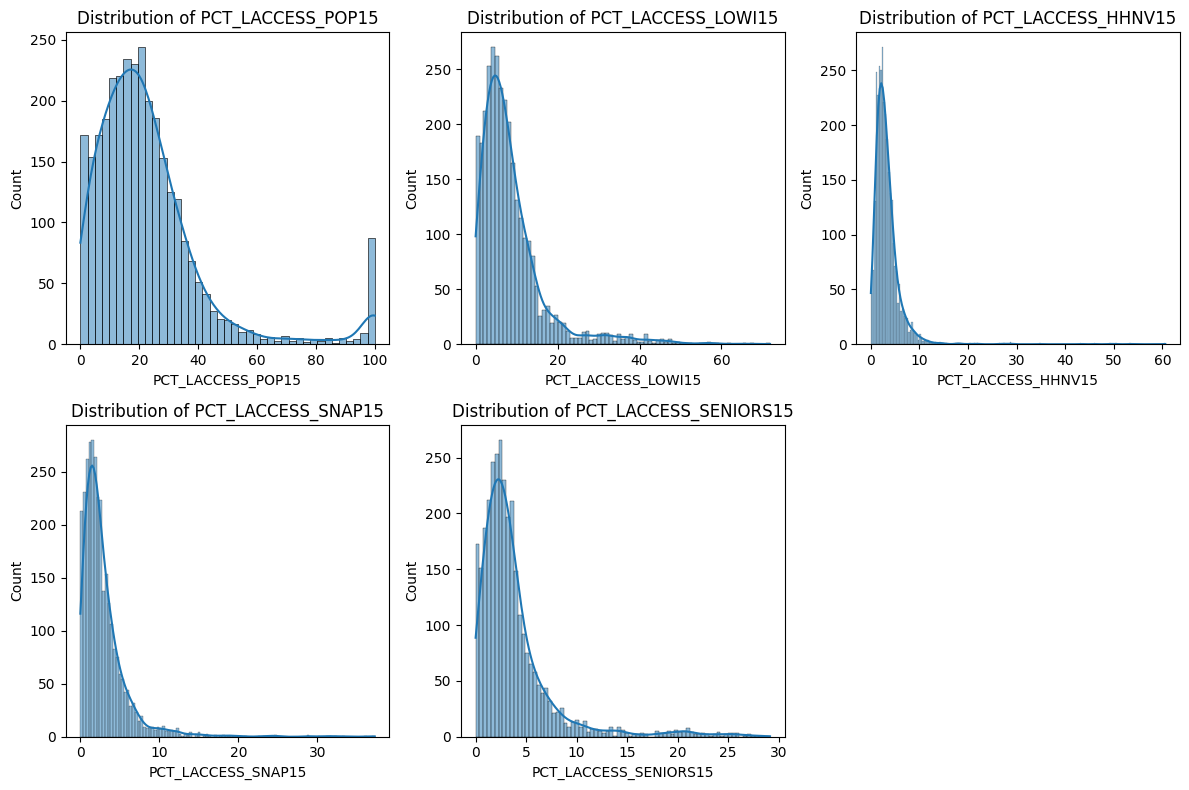

In [11]:
# List of features selected
features = [
    'PCT_LACCESS_POP15', 'PCT_LACCESS_LOWI15', 
    'PCT_LACCESS_HHNV15', 'PCT_LACCESS_SNAP15', 'PCT_LACCESS_SENIORS15' 
]

# Plotting the distributions
plt.figure(figsize=(12, 8))
for i, feature in enumerate(features):
    plt.subplot(2, 3, i + 1)
    sns.histplot(access_df_filtered[feature], kde=True)
    plt.title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()

In [12]:
# Check skewness and apply appropriate imputation method
for feature in features:
    if abs(access_df_filtered[feature].skew()) > 1:  # Check if skewness is greater than 1 or less than -1
        # Apply median imputation if the distribution is skewed
        median_value = access_df_filtered[feature].median()
        access_df_filtered.loc[:, feature] = access_df_filtered[feature].fillna(median_value)
        print(f"Median Imputation for feature: {feature}")
    else:
        # Apply mean imputation if the distribution is not skewed
        mean_value = access_df_filtered[feature].mean()
        access_df_filtered.loc[:, feature] = access_df_filtered[feature].fillna(mean_value)
        print(f"Mean Imputation for feature: {feature}")

Median Imputation for feature: PCT_LACCESS_POP15
Median Imputation for feature: PCT_LACCESS_LOWI15
Median Imputation for feature: PCT_LACCESS_HHNV15
Median Imputation for feature: PCT_LACCESS_SNAP15
Median Imputation for feature: PCT_LACCESS_SENIORS15


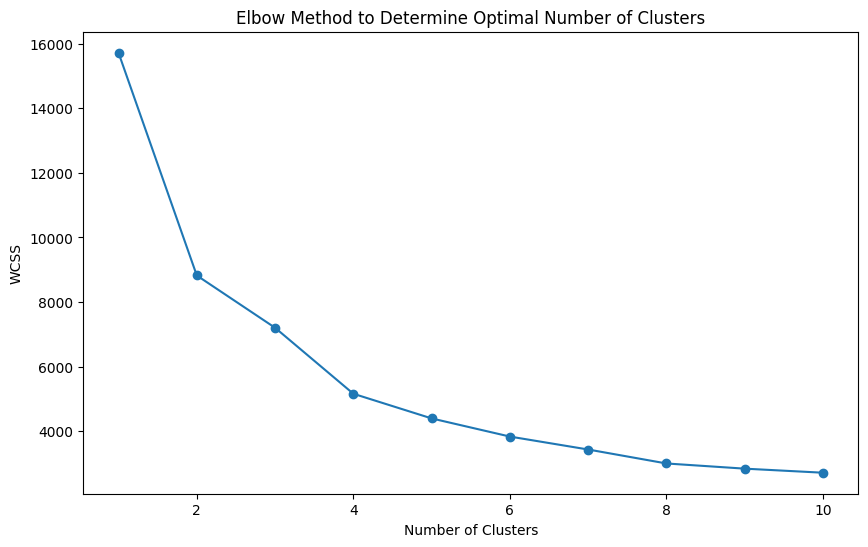

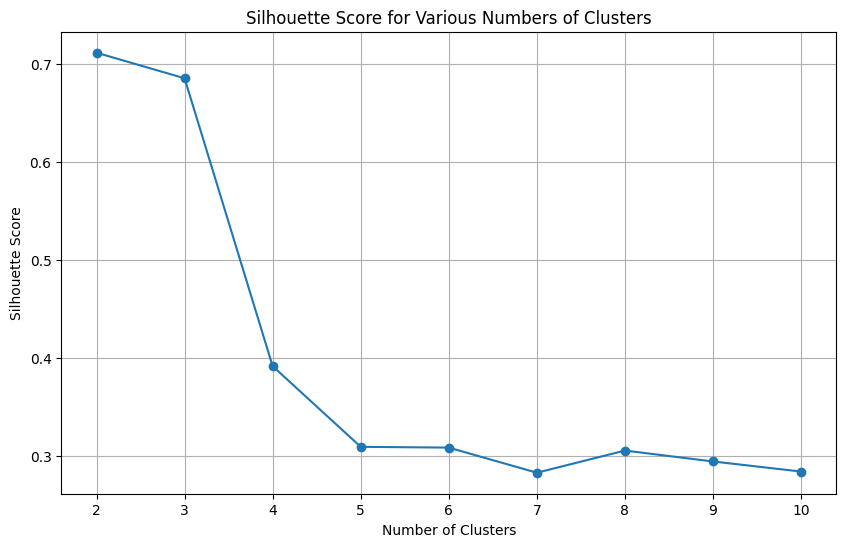

Silhouette Score: 0.732


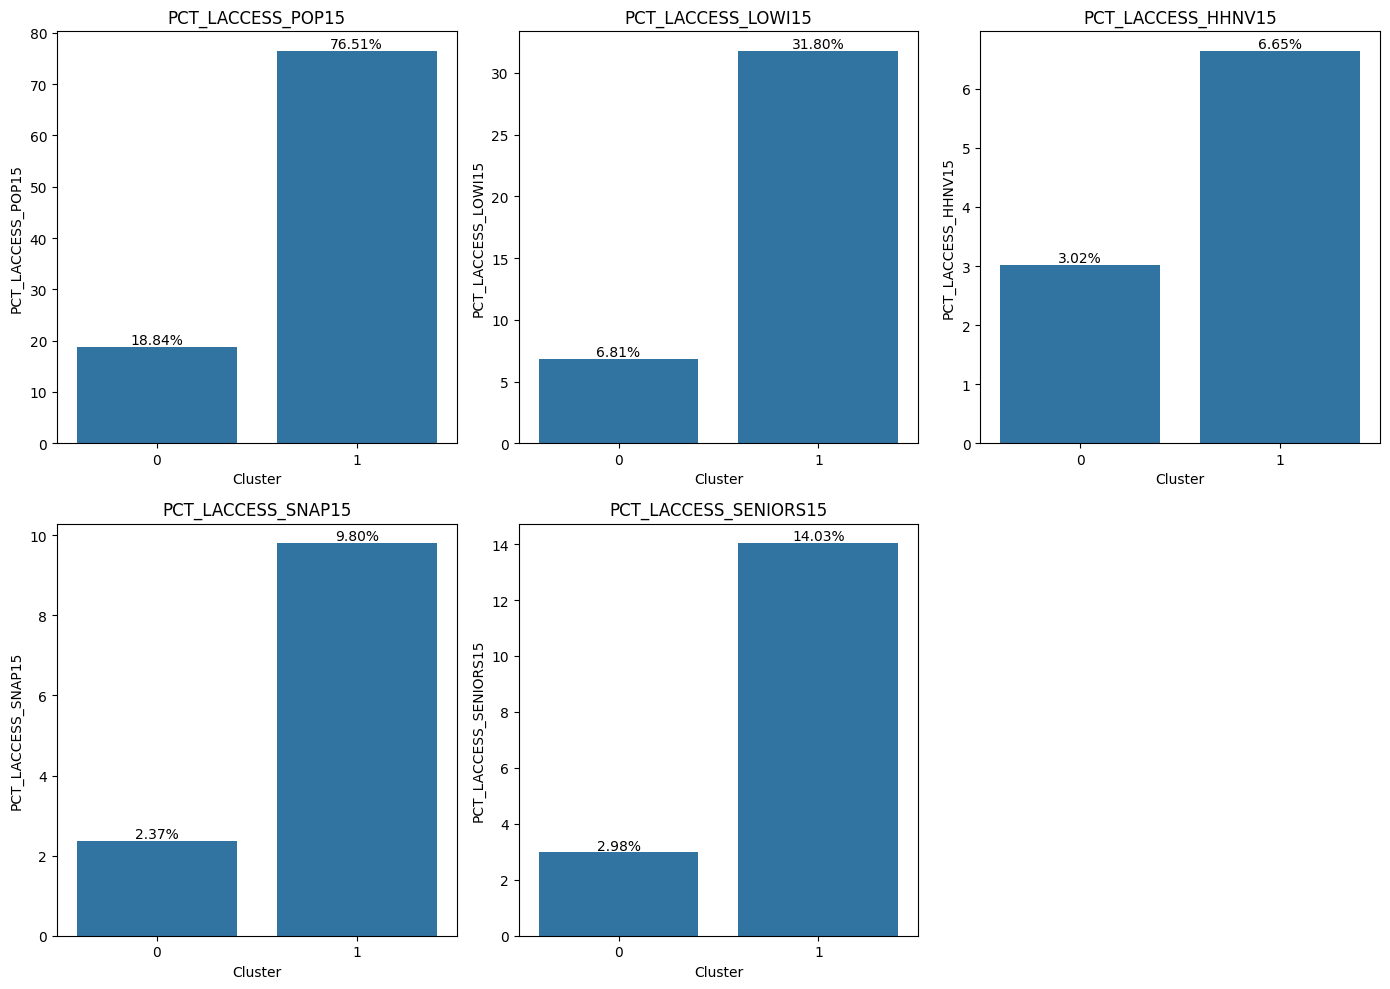

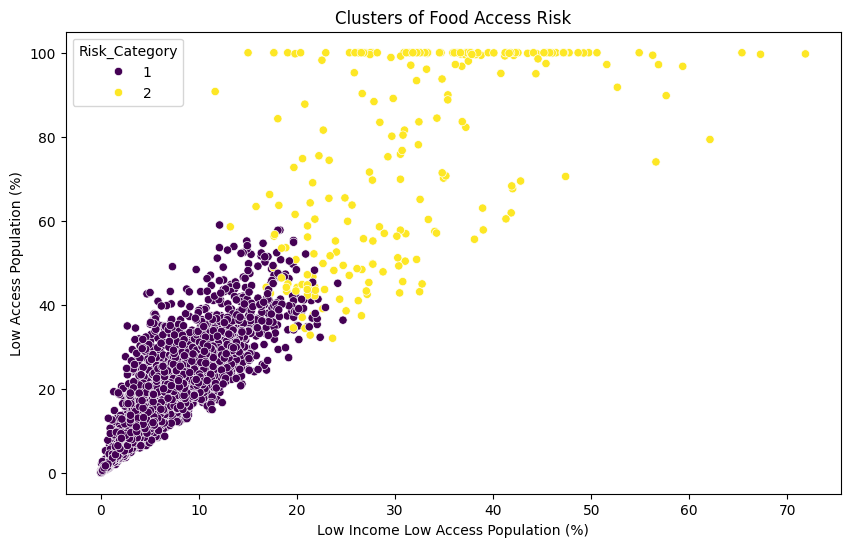

In [13]:
# Select numeric columns from the filtered dataframe for clustering analysis
numeric_cols = access_df_filtered.select_dtypes(include=['float64', 'int64']).columns

# Extract the specified features for clustering
X = access_df_filtered[features]

# Standardize the features to have mean=0 and variance=1 for better performance of K-means
scaler = StandardScaler()
scaled_features = scaler.fit_transform(X)

# Determine the optimal number of clusters using the Elbow method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(scaled_features)
    wcss.append(kmeans.inertia_)

# Plot the Within-Cluster-Sum of Squared Errors (WCSS) to find the elbow point
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method to Determine Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

# Calculate silhouette scores for cluster numbers to validate clustering quality
silhouette_scores = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    cluster_labels = kmeans.fit_predict(scaled_features)
    score = silhouette_score(scaled_features, cluster_labels)
    silhouette_scores.append(score)

# Plot silhouette scores across different cluster counts to identify the best number
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.title('Silhouette Score for Various Numbers of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

# Use the identified optimal cluster count to fit the final K-means model
optimal_clusters = 2  # Decided using high silhouette score and elbow point. 
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
access_df_filtered['Cluster'] = kmeans.fit_predict(scaled_features)

# Calculate and print silhouette score for the selected number of clusters
score = silhouette_score(X, access_df_filtered['Cluster'])
print('Silhouette Score: %.3f' % score)

# Visualize the distribution of features within clusters
cluster_summary = access_df_filtered.groupby('Cluster')[numeric_cols].mean()
plt.figure(figsize=(14, 10))
for i, feature in enumerate(features):
    plt.subplot(2, 3, i+1)
    ax = sns.barplot(x='Cluster', y=feature, data=access_df_filtered,errorbar=None)
    plt.title(feature)
    
    # Adding annotations on each bar
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                    textcoords='offset points')
plt.tight_layout()
plt.show()

# Calculate the mean risk score for each cluster and rank them to assign risk categories
cluster_summary['Risk_Score'] = cluster_summary[features].mean(axis=1)
cluster_summary['Risk_Category'] = cluster_summary['Risk_Score'].rank().astype(int)

# Map risk categories back to the main dataframe for analysis
risk_category_map = cluster_summary['Risk_Category'].to_dict()
access_df_filtered['Risk_Category'] = access_df_filtered['Cluster'].map(risk_category_map)

# Visualize the clustering of counties by risk category using a scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PCT_LACCESS_LOWI15', y='PCT_LACCESS_POP15', hue='Risk_Category', data=access_df_filtered, palette='viridis')
plt.title('Clusters of Food Access Risk')
plt.xlabel('Low Income Low Access Population (%)')
plt.ylabel('Low Access Population (%)')
plt.show()


In [14]:
cluster_summary

,PCT_LACCESS_POP10,PCT_LACCESS_POP15,PCT_LACCESS_LOWI10,PCT_LACCESS_LOWI15,PCT_LACCESS_HHNV10,PCT_LACCESS_HHNV15,PCT_LACCESS_SNAP15,PCT_LACCESS_CHILD10,PCT_LACCESS_CHILD15,PCT_LACCESS_SENIORS10,PCT_LACCESS_SENIORS15,PCT_LACCESS_WHITE15,PCT_LACCESS_BLACK15,PCT_LACCESS_HISP15,PCT_LACCESS_NHASIAN15,PCT_LACCESS_NHNA15,PCT_LACCESS_NHPI15,PCT_LACCESS_MULTIR15,Risk_Score,Risk_Category
Cluster,,,,,,,,,,,,,,,,,,,,
0,19.972571,18.841002,6.864750,6.808915,2.920984,3.023625,2.368994,4.661666,4.399588,3.211585,2.976081,15.597868,1.714449,1.539091,0.238814,0.338939,0.017274,0.931296,6.803724,1
1,68.986409,76.508079,27.502003,31.798577,6.111984,6.645065,9.801243,16.190399,18.102359,12.830381,14.032658,61.494932,3.958329,8.088321,0.381923,6.665810,0.043527,3.963559,27.757124,2


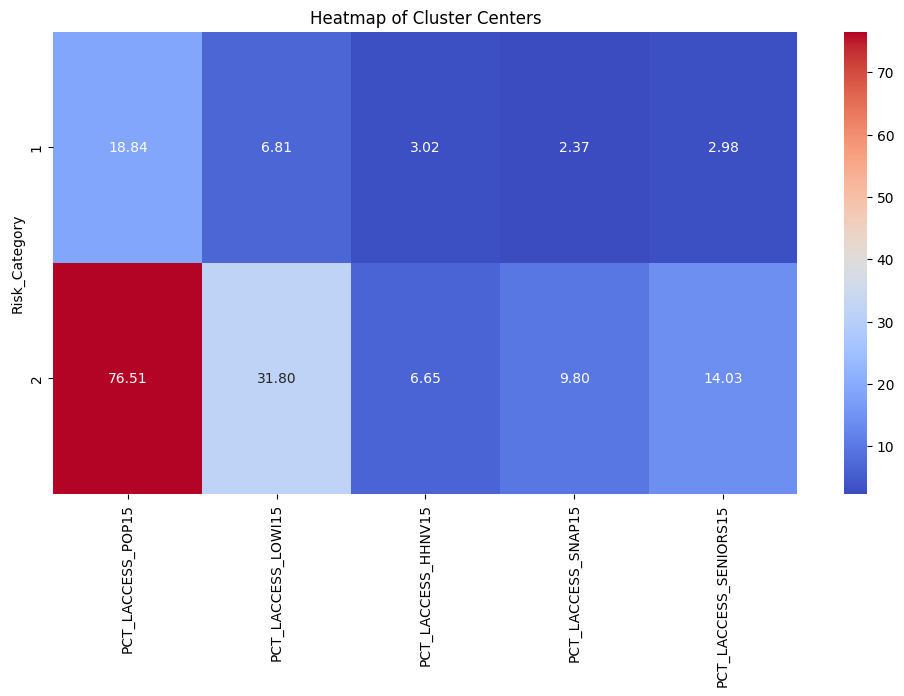

In [15]:
# Visualizing the mean values of each feature within each cluster using a heatmap 
# To prvide a quick overview of the defining characteristics of each cluster.

# Calculate cluster centers
cluster_centers = access_df_filtered.groupby('Risk_Category')[features].mean()

plt.figure(figsize=(12, 6))
sns.heatmap(cluster_centers, annot=True, cmap='coolwarm', fmt=".2f") 
plt.title('Heatmap of Cluster Centers')
plt.show()


In [16]:
access_df_filtered.head()

,FIPS,State,County,PCT_LACCESS_POP10,PCT_LACCESS_POP15,PCT_LACCESS_LOWI10,PCT_LACCESS_LOWI15,PCT_LACCESS_HHNV10,PCT_LACCESS_HHNV15,PCT_LACCESS_SNAP15,PCT_LACCESS_CHILD10,PCT_LACCESS_CHILD15,PCT_LACCESS_SENIORS10,PCT_LACCESS_SENIORS15,PCT_LACCESS_WHITE15,PCT_LACCESS_BLACK15,PCT_LACCESS_HISP15,PCT_LACCESS_NHASIAN15,PCT_LACCESS_NHNA15,PCT_LACCESS_NHPI15,PCT_LACCESS_MULTIR15,Cluster,Risk_Category
0,01001,AL,Autauga,33.769657,32.062255,9.793530,11.991125,3.284786,3.351332,4.608749,8.837112,8.460485,4.376378,3.996279,23.163613,7.726582,0.863345,0.159000,0.112092,0.016159,0.884808,0,1
1,01003,AL,Baldwin,19.318473,16.767489,5.460261,5.424427,2.147827,1.905114,1.298900,4.343199,3.844936,3.513570,3.061840,13.981393,1.942757,0.755973,0.116833,0.099662,0.008131,0.618712,0,1
2,01005,AL,Barbour,20.840972,22.105560,11.420316,10.739667,4.135869,4.329378,4.303147,3.425062,3.758341,2.805166,3.001695,10.302934,9.881360,1.855183,0.062266,0.145539,0.029436,1.684025,0,1
3,01007,AL,Bibb,4.559753,4.230324,2.144661,2.601627,3.458580,2.821427,0.676710,1.087518,1.015242,0.657008,0.600865,2.358770,1.828933,0.037516,0.008703,0.010967,0.000000,0.022951,0,1
4,01009,AL,Blount,2.700840,6.497380,1.062468,2.880150,3.269380,3.336414,0.812727,0.671490,1.588720,0.340269,0.882583,5.909147,0.167201,0.867886,0.014705,0.050484,0.001854,0.353990,0,1


### Food Desert Classification (a secondary analysis)
- Based on USDA food desert definition

According to the USDA, food deserts are defined by a lack of access to supermarkets,
grocery stores, or other sources of healthy and affordable foods [(link)](https://www.ers.usda.gov/amber-waves/2011/december/data-feature-mapping-food-deserts-in-the-u-s/). Census tracts qualify as food deserts if they meet low-income and low-access thresholds:

- Low-income: a poverty rate of 20 percent or greater, or a median family income at or below 80 percent of the statewide or metropolitan area median family income;
- Low-access: at least 500 persons and/or at least 33 percent of the population lives more than 1 mile from a supermarket or large grocery store (10 miles, in the case of rural census tracts).


Since Access data is at the county level, I have classified a county as a food desert using these thresholds. This is just a minor validation step. K-means analysis of risk scoring is the primary calculation since we cannot exactly map these threshold from tract-level to county level.

In [17]:
# Low-access: Using the percentage of population with low access
# access_df['Low_Access'] = (access_df['PCT_LACCESS_POP15'] >= 33)
access_df_filtered.loc[:, 'Low_Access'] = (access_df_filtered['PCT_LACCESS_POP15'] >= 33)

# Low-income: This will require external data woth exact poverty rate or income data
# df['Low_Income'] = (df['Poverty_Rate'] >= 20) | (df['Median_Family_Income'] <= 0.8 * statewide_median)
# 'PCT_LACCESS_LOWI15' indicates low-income and low-access
access_df_filtered.loc[:, 'Low_Income'] = (access_df_filtered['PCT_LACCESS_LOWI15'] >= 20)

# Food Desert definition
access_df_filtered.loc[:, 'Food_Desert'] = (access_df_filtered['Low_Access'] & access_df_filtered['Low_Income']).astype(int)


In [18]:
# a cross-tabulation between Food_Desert and Risk_Category to see how many entries fall into each category combination.
contingency_table = pd.crosstab(access_df_filtered['Food_Desert'], access_df_filtered['Risk_Category'])
print(contingency_table)

Risk_Category     1    2
Food_Desert             
0              2891   30
1                22  200


### Visualization and Analysis of States with High Food Access Risk Counties

In [19]:
pivot_table = pd.pivot_table(access_df_filtered, values='FIPS',  
                             index='State', 
                             columns='Risk_Category', 
                             aggfunc='count',
                             fill_value=0)

pivot_table.columns = ['low risk', 'high risk']

# Sort the dataframe by 'high' risk category in descending order
sorted_pivot_table = pivot_table.sort_values(by='high risk', ascending=False)
print(sorted_pivot_table)


       low risk  high risk
State                     
TX          222         32
SD           42         24
NE           73         20
MT           41         15
AK           16         13
ND           40         13
KS           93         12
OK           67         10
VA          126          8
NM           25          8
MS           74          8
MO          109          6
GA          153          6
NV           12          5
AZ           10          5
UT           24          5
AR           70          5
WA           35          4
CO           60          4
OR           32          4
ID           40          4
MN           84          3
AL           64          3
IA           96          3
IL          100          2
FL           65          2
TN           94          1
KY          119          1
NC           99          1
WV           54          1
OH           87          1
CA           57          1
RI            5          0
VT           14          0
SC           46          0
W

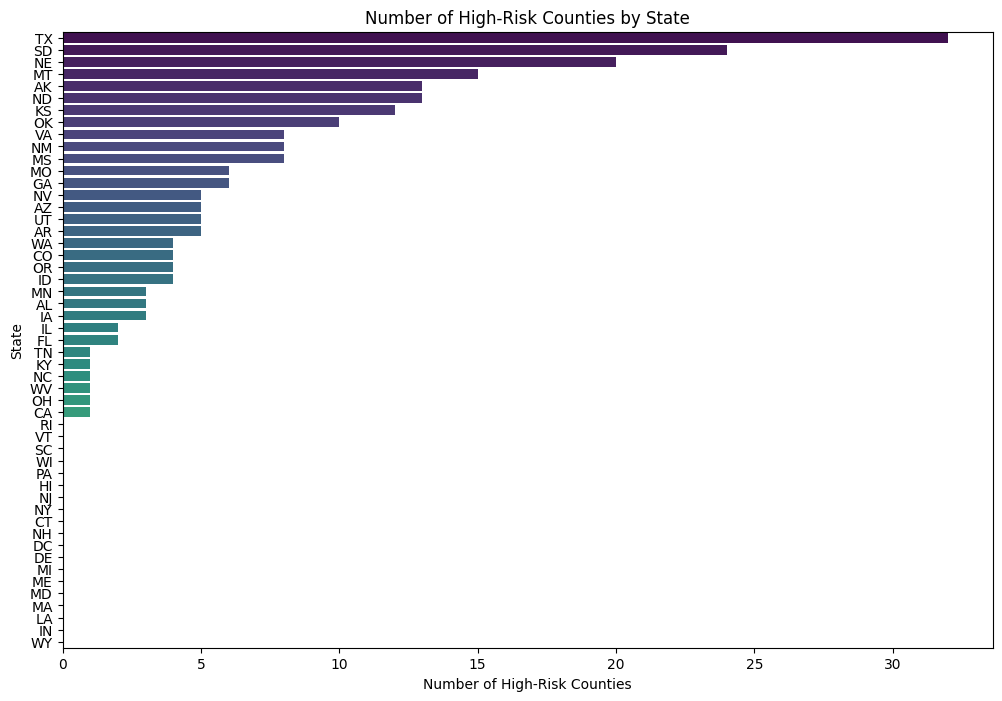

In [20]:
warnings.filterwarnings('ignore')

# Create a pivot table focusing only on high-risk (Risk_Category=2) counties
pivot_table_high_risk = pd.pivot_table(access_df_filtered, values='FIPS', 
                                       index='State', 
                                       columns='Risk_Category', 
                                       aggfunc='count',
                                       fill_value=0)

high_risk_counties = pivot_table_high_risk[2]

# Sort the results to see which states have the highest number of high-risk counties
high_risk_sorted = high_risk_counties.sort_values(ascending=False)
# high_risk_sorted

plt.figure(figsize=(12, 8))
sns.barplot(x=high_risk_sorted.values, y=high_risk_sorted.index, palette="viridis")
plt.title('Number of High-Risk Counties by State')
plt.xlabel('Number of High-Risk Counties')
plt.ylabel('State')
plt.show()

warnings.filterwarnings('default')

       High_Risk_Counties  Total_Counties  Proportion
State                                                
AK                     13              29    0.448276
SD                     24              66    0.363636
AZ                      5              15    0.333333
NV                      5              17    0.294118
MT                     15              56    0.267857
ND                     13              53    0.245283
NM                      8              33    0.242424
NE                     20              93    0.215054
UT                      5              29    0.172414
OK                     10              77    0.129870
TX                     32             254    0.125984


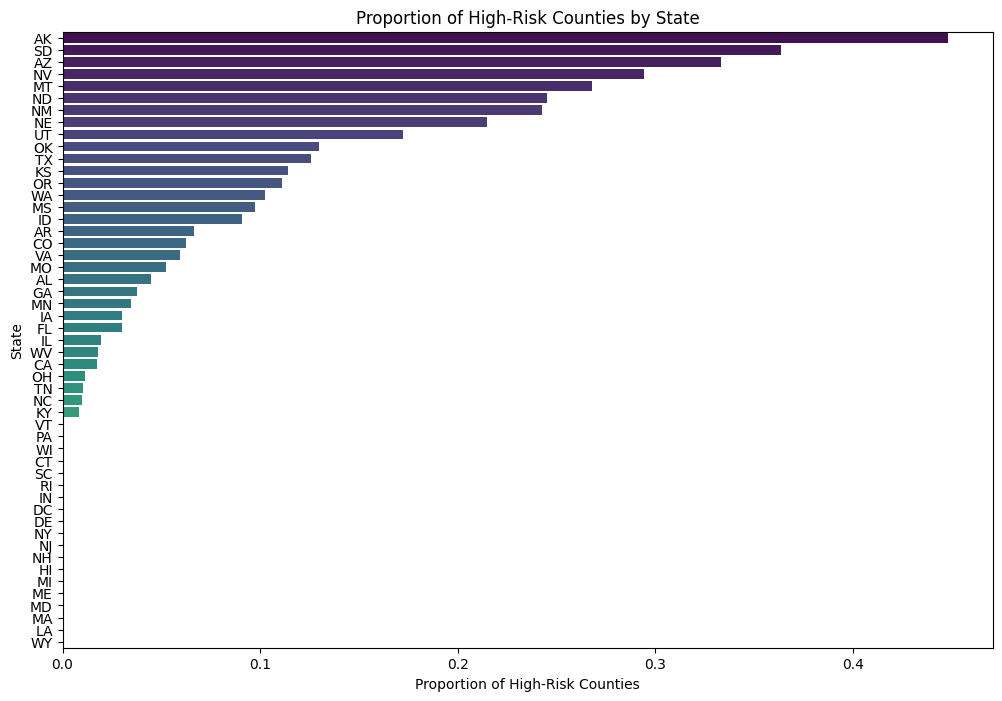

In [21]:
warnings.filterwarnings('ignore')
# Pivot table with the total count of counties per state
total_counties_per_state = pd.pivot_table(access_df_filtered, values='FIPS', 
                                          index='State', 
                                          aggfunc='nunique')

# Merge the total counts with the high-risk counts
high_risk_proportions = pd.DataFrame({
    'High_Risk_Counties': high_risk_counties,
    'Total_Counties': total_counties_per_state['FIPS']
})

# Calculate the proportion of high-risk counties
high_risk_proportions['Proportion'] = high_risk_proportions['High_Risk_Counties'] / high_risk_proportions['Total_Counties']

# Sort the results by the proportion of high-risk counties
high_risk_proportions_sorted = high_risk_proportions.sort_values(by='Proportion', ascending=False)
print(high_risk_proportions_sorted.head(11))

plt.figure(figsize=(12, 8))
sns.barplot(x=high_risk_proportions_sorted['Proportion'], y=high_risk_proportions_sorted.index, palette="viridis")
plt.title('Proportion of High-Risk Counties by State')
plt.xlabel('Proportion of High-Risk Counties')
plt.ylabel('State')
plt.show()

warnings.filterwarnings('default')

Observation:
- Alaska (AK) has the highest proportion of high-risk counties, with nearly 45% of its counties falling into the high food access risk category.
- South Dakota (SD) and Arizona (AZ) also show significant proportions of high-risk counties, exceeding 30%.
- Texas (TX), despite having the largest number of high-risk counties (32).
- In states like Alaska, South Dakota, and Arizona, which have high proportions of food deserts, there's a critical need for infrastructure development. Building more grocery stores and improving transportation options in these areas can significantly enhance food accessibility.

#### Map to visualize high food access risk counties.

In [22]:
#  https://www2.census.gov/geo/tiger/TIGER2021/COUNTY/

gdf_counties = gpd.read_file('tl_2021_us_county.shp')

gdf_counties['FIPS'] = gdf_counties['STATEFP'] + gdf_counties['COUNTYFP']
gdf_merged = gdf_counties.merge(access_df_filtered, on='FIPS')

# Filter for high-risk counties
high_risk_counties = gdf_merged[gdf_merged['Risk_Category'] == 2]


1. Choropleth Map

In [23]:
# Create the base map
m = folium.Map(location=[37.8, -96], zoom_start=3)  

# A function to color high-risk counties
def color_producer(risk_category):
    return 'red' if risk_category == 2 else 'transparent'  

# Manually add GeoJson layers for each high-risk county
for idx, row in high_risk_counties.iterrows():
    if row['Risk_Category'] == 2:  # only high-risk counties are added
        style = {
            'fillColor': color_producer(row['Risk_Category']),
            'color': 'black',  # Boundary color
            'weight': 0.4,     # Boundary width
            'fillOpacity': 0.5 # Fill opacity
        }
        tooltip_text = f"{row['NAME']} County, {row['State']}: High Food Access Risk"
        folium.GeoJson(
            row['geometry'],
            style_function=lambda x, style=style: style,
            tooltip=folium.Tooltip(tooltip_text)
        ).add_to(m)


m.save('high_food_access_risk_counties_choropleth_map.html')
# m  # Display 


Observations:
- The state of Alaska has the most region marked in high risk of food access category.
- The risk areas are majorly located in the west, midwest, southern region.

2. Marker Map

In [24]:
# Create a base map
m = folium.Map(location=[37.8, -96], zoom_start=5)


for idx, row in high_risk_counties.iterrows():
    folium.Marker(
        location=[row['INTPTLAT'], row['INTPTLON']],
        popup=f"{row['NAME']}, {row['State']}: High Food Access Risk",
        icon=folium.Icon(color='lightred', icon='exclamation-triangle', prefix='fa')
    ).add_to(m)

m.save('high_food_access_risk_counties_marker_map.html')
# m  # Display


In [25]:
columns_to_merge = ['FIPS', 'Low_Access', 'Low_Income', 'Food_Desert', 'Risk_Category']

df_to_merge = access_df_filtered[columns_to_merge]

# Merge these columns back into the original DataFrame using FIPS as the key
access_df = access_df.merge(df_to_merge, on='FIPS', how='left', suffixes=('', '_new'))

for column in ['Low_Access', 'Low_Income', 'Food_Desert', 'Risk_Category']:
    if column + '_new' in access_df.columns:
        access_df[column] = access_df[column + '_new']
        access_df.drop(column + '_new', axis=1, inplace=True)

access_df

,index,FIPS,State,County,LACCESS_POP10,LACCESS_POP15,PCH_LACCESS_POP_10_15,PCT_LACCESS_POP10,PCT_LACCESS_POP15,LACCESS_LOWI10,LACCESS_LOWI15,PCH_LACCESS_LOWI_10_15,PCT_LACCESS_LOWI10,PCT_LACCESS_LOWI15,LACCESS_HHNV10,LACCESS_HHNV15,PCH_LACCESS_HHNV_10_15,PCT_LACCESS_HHNV10,PCT_LACCESS_HHNV15,LACCESS_SNAP15,PCT_LACCESS_SNAP15,LACCESS_CHILD10,LACCESS_CHILD15,LACCESS_CHILD_10_15,PCT_LACCESS_CHILD10,PCT_LACCESS_CHILD15,LACCESS_SENIORS10,LACCESS_SENIORS15,PCH_LACCESS_SENIORS_10_15,PCT_LACCESS_SENIORS10,PCT_LACCESS_SENIORS15,LACCESS_WHITE15,PCT_LACCESS_WHITE15,LACCESS_BLACK15,PCT_LACCESS_BLACK15,LACCESS_HISP15,PCT_LACCESS_HISP15,LACCESS_NHASIAN15,PCT_LACCESS_NHASIAN15,LACCESS_NHNA15,PCT_LACCESS_NHNA15,LACCESS_NHPI15,PCT_LACCESS_NHPI15,LACCESS_MULTIR15,PCT_LACCESS_MULTIR15,Low_Access,Low_Income,Food_Desert,Risk_Category
0,0,01001,AL,Autauga,18428.439685,17496.693038,-5.056026,33.769657,32.062255,5344.427472,6543.676824,22.439248,9.793530,11.991125,664.216487,677.672769,2.025888,3.284786,3.351332,931.935186,4.608749,4822.500269,4616.971480,-4.261872,8.837112,8.460485,2388.233228,2180.809285,-8.685247,4.376378,3.996279,12640.615414,23.163613,4216.473194,7.726582,471.136164,0.863345,86.767975,0.159000,61.169869,0.112092,8.817961,0.016159,482.848633,0.884808,False,False,0,1
1,1,01003,AL,Baldwin,35210.814078,30561.264430,-13.204891,19.318473,16.767489,9952.144027,9886.831137,-0.656270,5.460261,5.424427,1571.779915,1394.162766,-11.300383,2.147827,1.905114,950.535290,1.298900,7916.131932,7007.972675,-11.472260,4.343199,3.844936,6404.008603,5580.662790,-12.856726,3.513570,3.061840,25483.186811,13.981393,3540.965826,1.942757,1377.874834,0.755973,212.946378,0.116833,181.649648,0.099662,14.819634,0.008131,1127.696098,0.618712,False,False,0,1
2,2,01005,AL,Barbour,5722.305602,6069.523628,6.067799,20.840972,22.105560,3135.676086,2948.790251,-5.959985,11.420316,10.739667,406.142372,425.144927,4.678792,4.135869,4.329378,422.569040,4.303147,940.419327,1031.927776,9.730601,3.425062,3.758341,770.214550,824.175262,7.005933,2.805166,3.001695,2828.876711,10.302934,2713.124930,9.881360,509.377525,1.855183,17.096410,0.062266,39.960527,0.145539,8.082376,0.029436,462.382655,1.684025,False,False,0,1
3,3,01007,AL,Bibb,1044.867327,969.378841,-7.224696,4.559753,4.230324,491.449066,596.162829,21.307144,2.144661,2.601627,275.060875,224.388125,-18.422377,3.458580,2.821427,53.818772,0.676710,249.204753,232.642670,-6.645974,1.087518,1.015242,150.553323,137.688231,-8.545207,0.657008,0.600865,540.512239,2.358770,419.099942,1.828933,8.596762,0.037516,1.994318,0.008703,2.513097,0.010967,0.000000,0.000000,5.259244,0.022951,False,False,0,1
4,4,01009,AL,Blount,1548.175559,3724.428242,140.568857,2.700840,6.497380,609.027708,1650.959482,171.081177,1.062468,2.880150,705.466783,719.931444,2.050367,3.269380,3.336414,175.370338,0.812727,384.911607,910.686113,136.596168,0.671490,1.588720,195.049051,505.914282,159.377977,0.340269,0.882583,3387.241266,5.909147,95.842687,0.167201,497.489891,0.867886,8.428994,0.014705,28.938242,0.050484,1.062851,0.001854,202.914187,0.353990,False,False,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3138,3138,56037,WY,Sweetwater,13391.715505,18934.737809,41.391428,30.570505,43.224074,2414.618816,4750.905615,96.755926,5.512073,10.845331,144.507890,359.608360,148.850330,0.877134,2.182752,352.866113,2.141828,3583.869531,4852.757500,35.405529,8.181230,11.077838,1240.913685,1951.212126,57.239956,2.832748,4.454212,16811.003936,38.376031,186.278452,0.425235,2661.350520,6.075311,114.722086,0.261887,189.621441,0.432866,27.720443,0.063280,1605.391465,3.664775,True,False,0,1
3139,3139,56039,WY,Teton,6212.423697,6212.390430,-0.000535,29.174527,29.174370,1059.463554,1577.771012,48.921688,4.975409,7.409463,123.365110,48.474161,-60.706750,1.374848,0.540222,60.192270,0.670815,1096.195276,1096.186959,-0.000759,5.147

## **Step 2:** 500 Cities Dataset Analysis - Health Outcome Analysis of Tracts within the Counties


### Access Data is merged with Cities Data to add the Risk Category, Food Desert flag columns.


In [26]:
warnings.filterwarnings('ignore')


In [27]:
access_df['FIPS'] = access_df['FIPS'].astype(str)

five_hundred_cities_df['FIPS'] = five_hundred_cities_df['FIPS'].astype(str)

# Perform the merge operation
merged_df = five_hundred_cities_df.merge(access_df[['FIPS', 'Food_Desert','Risk_Category']], on='FIPS', how='left')


merged_df.columns

Index(['index', 'StateAbbr', 'PlaceName', 'PlaceFIPS', 'TractFIPS',
       'Place_TractID', 'Population2010', 'ACCESS2_CrudePrev',
       'ACCESS2_Crude95CI', 'ARTHRITIS_CrudePrev', 'ARTHRITIS_Crude95CI',
       'BINGE_CrudePrev', 'BINGE_Crude95CI', 'BPHIGH_CrudePrev',
       'BPHIGH_Crude95CI', 'BPMED_CrudePrev', 'BPMED_Crude95CI',
       'CANCER_CrudePrev', 'CANCER_Crude95CI', 'CASTHMA_CrudePrev',
       'CASTHMA_Crude95CI', 'CHD_CrudePrev', 'CHD_Crude95CI',
       'CHECKUP_CrudePrev', 'CHECKUP_Crude95CI', 'CHOLSCREEN_CrudePrev',
       'CHOLSCREEN_Crude95CI', 'COLON_SCREEN_CrudePrev',
       'COLON_SCREEN_Crude95CI', 'COPD_CrudePrev', 'COPD_Crude95CI',
       'COREM_CrudePrev', 'COREM_Crude95CI', 'COREW_CrudePrev',
       'COREW_Crude95CI', 'CSMOKING_CrudePrev', 'CSMOKING_Crude95CI',
       'DENTAL_CrudePrev', 'DENTAL_Crude95CI', 'DIABETES_CrudePrev',
       'DIABETES_Crude95CI', 'HIGHCHOL_CrudePrev', 'HIGHCHOL_Crude95CI',
       'KIDNEY_CrudePrev', 'KIDNEY_Crude95CI', 'LPA_CrudePre

In [28]:
# Grouping data and calculating mean prevalence rates for each condition across risk categories
grouped_data = merged_df.groupby('Risk_Category').agg({col: 'mean' for col in merged_df.columns if 'CrudePrev' in col})
grouped_data

,ACCESS2_CrudePrev,ARTHRITIS_CrudePrev,BINGE_CrudePrev,BPHIGH_CrudePrev,BPMED_CrudePrev,CANCER_CrudePrev,CASTHMA_CrudePrev,CHD_CrudePrev,CHECKUP_CrudePrev,CHOLSCREEN_CrudePrev,COLON_SCREEN_CrudePrev,COPD_CrudePrev,COREM_CrudePrev,COREW_CrudePrev,CSMOKING_CrudePrev,DENTAL_CrudePrev,DIABETES_CrudePrev,HIGHCHOL_CrudePrev,KIDNEY_CrudePrev,LPA_CrudePrev,MAMMOUSE_CrudePrev,MHLTH_CrudePrev,OBESITY_CrudePrev,PAPTEST_CrudePrev,PHLTH_CrudePrev,SLEEP_CrudePrev,STROKE_CrudePrev,TEETHLOST_CrudePrev
Risk_Category,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,16.982162,21.426952,18.072761,30.643443,70.738632,5.64902,9.739838,5.601622,69.003119,78.742454,61.789851,6.307622,31.66631,29.837003,17.967464,61.241545,10.806967,31.363609,3.098771,27.581961,79.186773,13.918521,30.463005,83.084189,12.880725,36.706864,3.2098,16.097596
2,26.508000,24.884000,11.752000,41.272000,76.880000,5.53200,11.388000,7.076000,77.972000,78.968000,57.864000,8.852000,26.57600,25.100000,24.044000,51.488000,15.264000,32.112000,4.072000,40.328000,83.756000,16.660000,41.256000,84.644000,15.316000,47.560000,5.0240,27.512000


In [29]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27210 entries, 0 to 27209
Data columns (total 67 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   index                   27210 non-null  int64  
 1   StateAbbr               27210 non-null  object 
 2   PlaceName               27210 non-null  object 
 3   PlaceFIPS               27210 non-null  int64  
 4   TractFIPS               27210 non-null  int64  
 5   Place_TractID           27210 non-null  object 
 6   Population2010          27210 non-null  int64  
 7   ACCESS2_CrudePrev       27209 non-null  float64
 8   ACCESS2_Crude95CI       27209 non-null  object 
 9   ARTHRITIS_CrudePrev     27210 non-null  float64
 10  ARTHRITIS_Crude95CI     27210 non-null  object 
 11  BINGE_CrudePrev         27210 non-null  float64
 12  BINGE_Crude95CI         27210 non-null  object 
 13  BPHIGH_CrudePrev        27210 non-null  float64
 14  BPHIGH_Crude95CI        27210 non-null

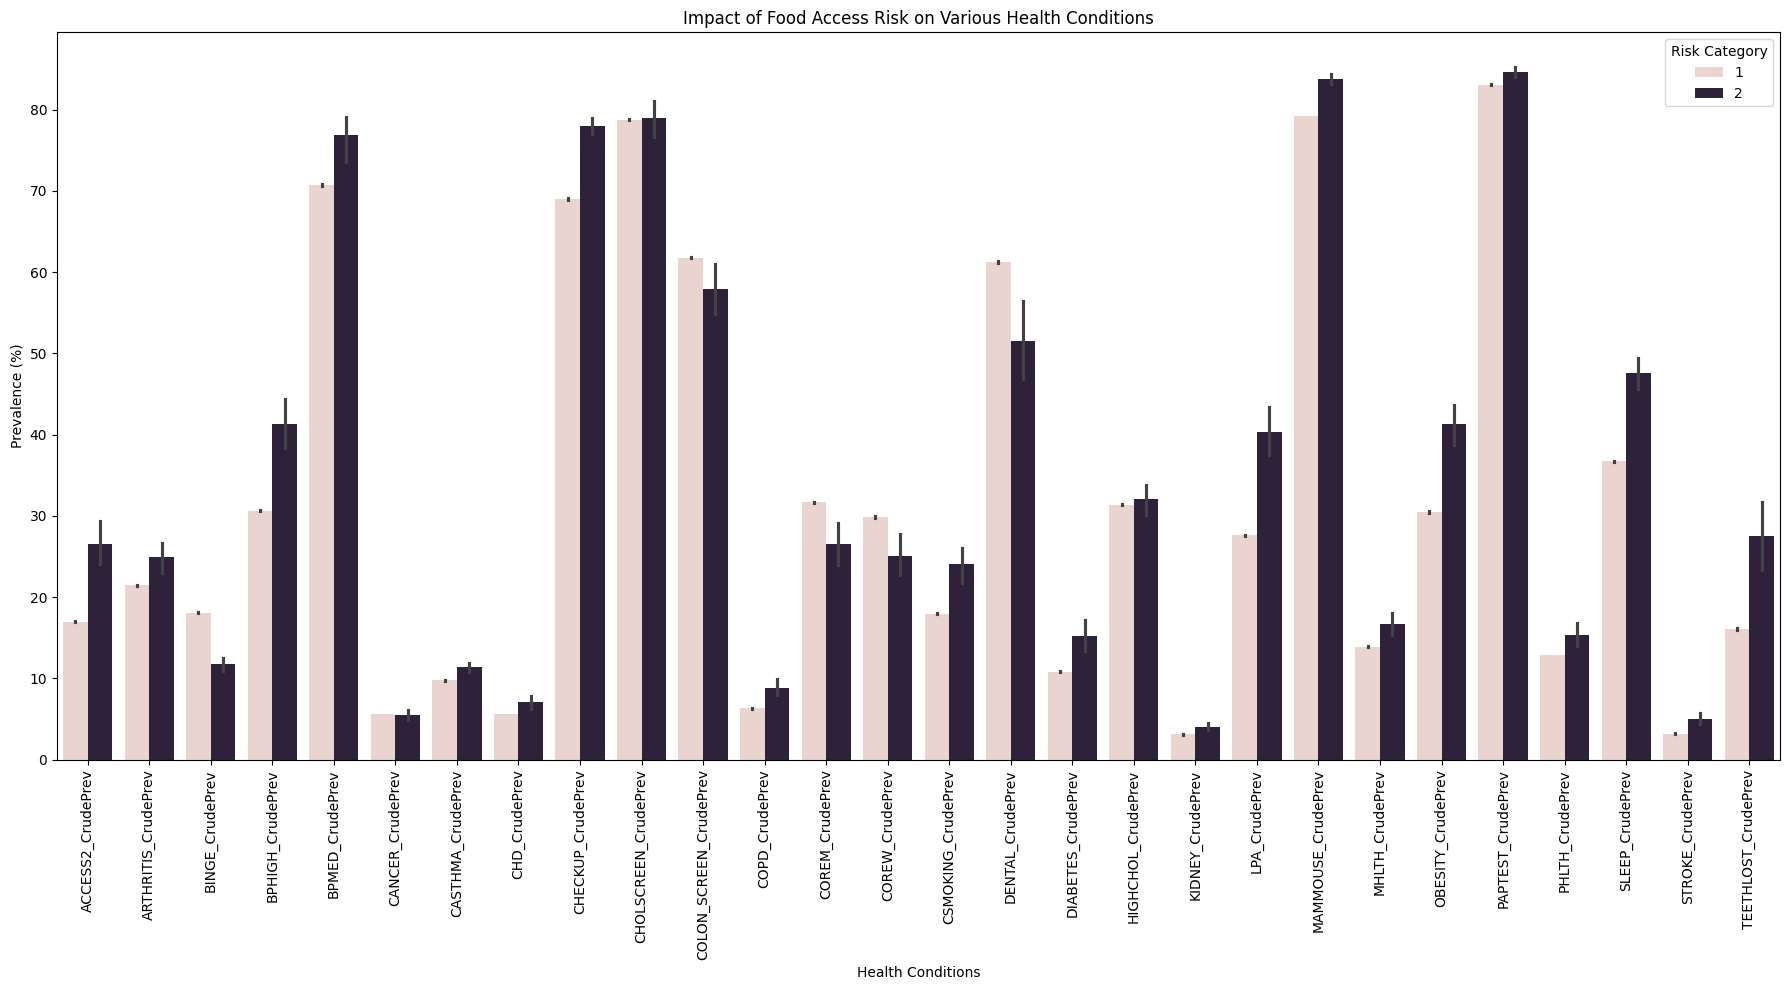

In [30]:
diseases=[]
for col in merged_df.columns:
    if 'CrudePrev' in col:
        diseases.append(col)

plot_data = merged_df.melt(id_vars=["Risk_Category"], value_vars=diseases, var_name='Disease', value_name='Prevalence')

plt.figure(figsize=(18, 10))
sns.barplot(x='Disease', y='Prevalence', hue='Risk_Category', data=plot_data)
plt.title('Impact of Food Access Risk on Various Health Conditions')
plt.ylabel('Prevalence (%)')
plt.xlabel('Health Conditions')
plt.xticks(rotation=90) 
plt.legend(title='Risk Category')
plt.tight_layout()
plt.show()

Disease
Physical Inactivity                                       12.746039
All Teeth Lost                                            11.414404
Sleep Disorders                                           10.853136
Obesity                                                   10.792995
High Blood Pressure                                       10.628557
No Health Insurance                                        9.525838
Doctor Visits                                              8.968881
Taking High BP Medicines                                   6.141368
Smoking                                                    6.076536
Mammography                                                4.569227
Diabetes                                                   4.457033
Arthritis                                                  3.457048
Poor Mental Health                                         2.741479
Chronic Obstructive Pulmonary Disease (COPD)               2.544378
Poor Physical Health                    

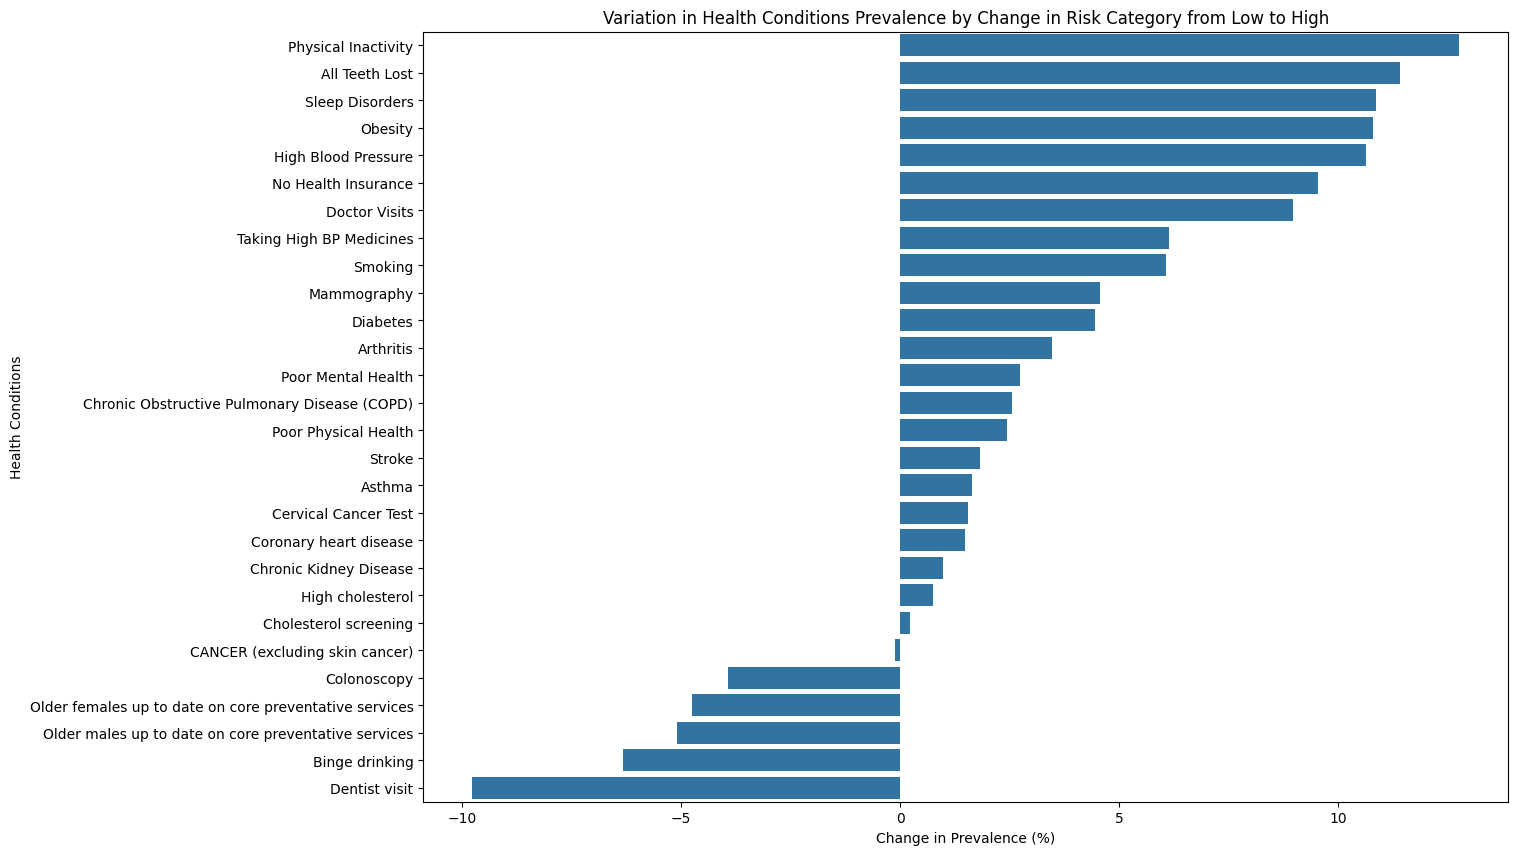

In [31]:
# A dictionary to map technical names to user-friendly names
full_names = {
    'SLEEP_CrudePrev': 'Sleep Disorders',
    'LPA_CrudePrev': 'Physical Inactivity',
    'OBESITY_CrudePrev': 'Obesity',
    'BPHIGH_CrudePrev': 'High Blood Pressure',
    'CASTHMA_CrudePrev': 'Asthma',
    'STROKE_CrudePrev': 'Stroke',
    'TEETHLOST_CrudePrev': 'All Teeth Lost',
    'COPD_CrudePrev': 'Chronic Obstructive Pulmonary Disease (COPD)',
    'DIABETES_CrudePrev': 'Diabetes',
    'KIDNEY_CrudePrev': 'Chronic Kidney Disease',
    'ACCESS2_CrudePrev': 'No Health Insurance',
    'CHECKUP_CrudePrev': 'Doctor Visits',
    'BPMED_CrudePrev': 'Taking High BP Medicines',
    'CSMOKING_CrudePrev': 'Smoking',
    'MAMMOUSE_CrudePrev': 'Mammography',
    'ARTHRITIS_CrudePrev': 'Arthritis',
    'MHLTH_CrudePrev': 'Poor Mental Health',
    'PHLTH_CrudePrev': 'Poor Physical Health',
    'PAPTEST_CrudePrev': 'Cervical Cancer Test',
    'CHD_CrudePrev': 'Coronary heart disease',
    'HIGHCHOL_CrudePrev': 'High cholesterol',
    'CHOLSCREEN_CrudePrev': 'Cholesterol screening',
    'CANCER_CrudePrev': 'CANCER (excluding skin cancer)',
    'COLON_SCREEN_CrudePrev': 'Colonoscopy',
    'COREW_CrudePrev': 'Older females up to date on core preventative services',
    'COREM_CrudePrev': 'Older males up to date on core preventative services',
    'BINGE_CrudePrev': 'Binge drinking',
    'DENTAL_CrudePrev': 'Dentist visit'
}

# Calculate mean prevalence for each disease and risk category
grouped_data = plot_data.groupby(['Risk_Category', 'Disease']).agg({'Prevalence': 'mean'}).reset_index()

# Pivot the data to have risk categories as columns
pivot_data = grouped_data.pivot(index='Disease', columns='Risk_Category', values='Prevalence')
pivot_data.index = pivot_data.index.map(full_names)

# Calculate the difference in prevalence between risk categories 1 and 2
pivot_data['Variation'] = pivot_data[2] - pivot_data[1]

# Sort the data by Variation to see the most affected conditions
sorted_variation = pivot_data.sort_values('Variation', ascending=False)
print(sorted_variation['Variation'])


plt.figure(figsize=(14, 10))
sns.barplot(x=sorted_variation['Variation'], y=sorted_variation.index)
plt.title('Variation in Health Conditions Prevalence by Change in Risk Category from Low to High')
plt.xlabel('Change in Prevalence (%)')
plt.ylabel('Health Conditions')
plt.show()

**Observation:**
- We can observe that prevalence of conditions like Obesity, Diabetes, Less Sleep, High Blood Pressure and Cholesterol, Chronic Obstructive Pulmonary Disease, Stroke, CHD, CKD, Poor Mental and Physical Health is higher for areas with High Food Access Risk (Risk Category:2).
- Prevalence of no leisure-time physical activity is also quite high for areas that high food access risk compared to areas with low food access risk.
- We can observe a high variation in uninsured population percentage between high and low food access risk areas.



Analysis from a USDA National Health Interview Survey indicated that the number of chronic conditions for adults in food-insecure households was, on average, 18% higher than for those in food-secure households. Further, the analysis found that food security status of adults was also strongly related to the number of chronic conditions reported, and lower food security was associated with a higher probability of all the chronic diseases examined in the report:

- Hypertension
- Coronary heart disease (CHD)
- Stroke
- Cancer
- Asthma
- Diabetes
- Arthritis
- Chronic obstructive pulmonary disease (COPD)

Mari Gallagher Research & Consulting Group (2010) defines food deserts as “having an imbalance of
food choice, meaning a heavy concentration of nearby fringe food that is high in salt, fat, and sugar. Many
fringe locations also offer “quick meals” that are very convenient but cannot support a healthy diet on a regular
basis. The study of Food Deserts is important for every type of community – urban, suburban and rural –
because findings from our studies reveal that residents of Food Deserts suffer worse diet-related health
outcomes, including diabetes, cancer, obesity, heart disease and premature death. These effects are independent
from other contributing factors such as income, race, and education. For diabetes and obesity, we have found
these relationships to be statistically significant.”  [link](https://chronicdisease.org/resource/resmgr/healthequity/hec_food_desert_final_11_02_.pdf)


### Merged Data is filtered to include conditions that are possibly prevailing due to poor food access based on above analysis

In [32]:
merged_df.drop(['ACCESS2_CrudePrev',
       'ACCESS2_Crude95CI','BINGE_CrudePrev', 'BINGE_Crude95CI', 'COLON_SCREEN_CrudePrev',
       'COLON_SCREEN_Crude95CI','CSMOKING_CrudePrev', 'CSMOKING_Crude95CI',
       'DENTAL_CrudePrev', 'DENTAL_Crude95CI','COREM_CrudePrev','COREM_Crude95CI','COREW_CrudePrev',
       'COREW_Crude95CI','CANCER_CrudePrev','CANCER_Crude95CI'],axis=1,inplace=True)


merged_df.columns

Index(['index', 'StateAbbr', 'PlaceName', 'PlaceFIPS', 'TractFIPS',
       'Place_TractID', 'Population2010', 'ARTHRITIS_CrudePrev',
       'ARTHRITIS_Crude95CI', 'BPHIGH_CrudePrev', 'BPHIGH_Crude95CI',
       'BPMED_CrudePrev', 'BPMED_Crude95CI', 'CASTHMA_CrudePrev',
       'CASTHMA_Crude95CI', 'CHD_CrudePrev', 'CHD_Crude95CI',
       'CHECKUP_CrudePrev', 'CHECKUP_Crude95CI', 'CHOLSCREEN_CrudePrev',
       'CHOLSCREEN_Crude95CI', 'COPD_CrudePrev', 'COPD_Crude95CI',
       'DIABETES_CrudePrev', 'DIABETES_Crude95CI', 'HIGHCHOL_CrudePrev',
       'HIGHCHOL_Crude95CI', 'KIDNEY_CrudePrev', 'KIDNEY_Crude95CI',
       'LPA_CrudePrev', 'LPA_Crude95CI', 'MAMMOUSE_CrudePrev',
       'MAMMOUSE_Crude95CI', 'MHLTH_CrudePrev', 'MHLTH_Crude95CI',
       'OBESITY_CrudePrev', 'OBESITY_Crude95CI', 'PAPTEST_CrudePrev',
       'PAPTEST_Crude95CI', 'PHLTH_CrudePrev', 'PHLTH_Crude95CI',
       'SLEEP_CrudePrev', 'SLEEP_Crude95CI', 'STROKE_CrudePrev',
       'STROKE_Crude95CI', 'TEETHLOST_CrudePrev', 'TEETH

In [33]:
# List of columns for health conditions
health_conditions = [
    'ARTHRITIS_CrudePrev', 'BPHIGH_CrudePrev',
    'CASTHMA_CrudePrev', 'CHD_CrudePrev',
    'COPD_CrudePrev', 'DIABETES_CrudePrev', 'HIGHCHOL_CrudePrev',
    'KIDNEY_CrudePrev','LPA_CrudePrev', 'MHLTH_CrudePrev', 'OBESITY_CrudePrev',
    'PHLTH_CrudePrev', 'STROKE_CrudePrev','SLEEP_CrudePrev','TEETHLOST_CrudePrev'
]

# List of columns for doctor or dentist visits/screening/checkup
health_services = [
    'CHECKUP_CrudePrev','BPMED_CrudePrev', 'CHOLSCREEN_CrudePrev', 'MAMMOUSE_CrudePrev', 'PAPTEST_CrudePrev', 
]



In [34]:
# Filter the DataFrame for high and low risk areas
high_risk_df = merged_df[merged_df['Risk_Category'] == 2]
low_risk_df = merged_df[merged_df['Risk_Category'] == 1]

# Calculate mean prevalence of each condition in high-risk areas
high_risk_health_conditions = high_risk_df[health_conditions].mean()
low_risk_health_conditions = low_risk_df[health_conditions].mean()

high_risk_health_conditions = high_risk_health_conditions.rename(index=full_names)
low_risk_health_conditions = low_risk_health_conditions.rename(index=full_names)

health_conditions_comparison = pd.DataFrame({
    'High Risk': high_risk_health_conditions,
    'Low Risk': low_risk_health_conditions
})

# Calculate the difference
health_conditions_comparison['Difference'] = health_conditions_comparison['High Risk'] - health_conditions_comparison['Low Risk']

health_conditions_comparison



,High Risk,Low Risk,Difference
Arthritis,24.884,21.426952,3.457048
High Blood Pressure,41.272,30.643443,10.628557
Asthma,11.388,9.739838,1.648162
Coronary heart disease,7.076,5.601622,1.474378
Chronic Obstructive Pulmonary Disease (COPD),8.852,6.307622,2.544378
Diabetes,15.264,10.806967,4.457033
High cholesterol,32.112,31.363609,0.748391
Chronic Kidney Disease,4.072,3.098771,0.973229
Physical Inactivity,40.328,27.581961,12.746039
Poor Mental Health,16.660,13.918521,2.741479


In [35]:
# Calculate the mean prevalence of health service usage in high-risk areas
high_risk_health_services = high_risk_df[health_services].mean()

# Compare with low-risk data
low_risk_health_services = low_risk_df[health_services].mean()

high_risk_health_services = high_risk_health_services.rename(index=full_names)
low_risk_health_services = low_risk_health_services.rename(index=full_names)

health_services_comparison = pd.DataFrame({
    'High Risk': high_risk_health_services,
    'Low Risk': low_risk_health_services
})

# Calculate the difference
health_services_comparison['Difference'] = health_services_comparison['High Risk'] - health_services_comparison['Low Risk']

health_services_comparison



,High Risk,Low Risk,Difference
Doctor Visits,77.972,69.003119,8.968881
Taking High BP Medicines,76.880,70.738632,6.141368
Cholesterol screening,78.968,78.742454,0.225546
Mammography,83.756,79.186773,4.569227
Cervical Cancer Test,84.644,83.084189,1.559811


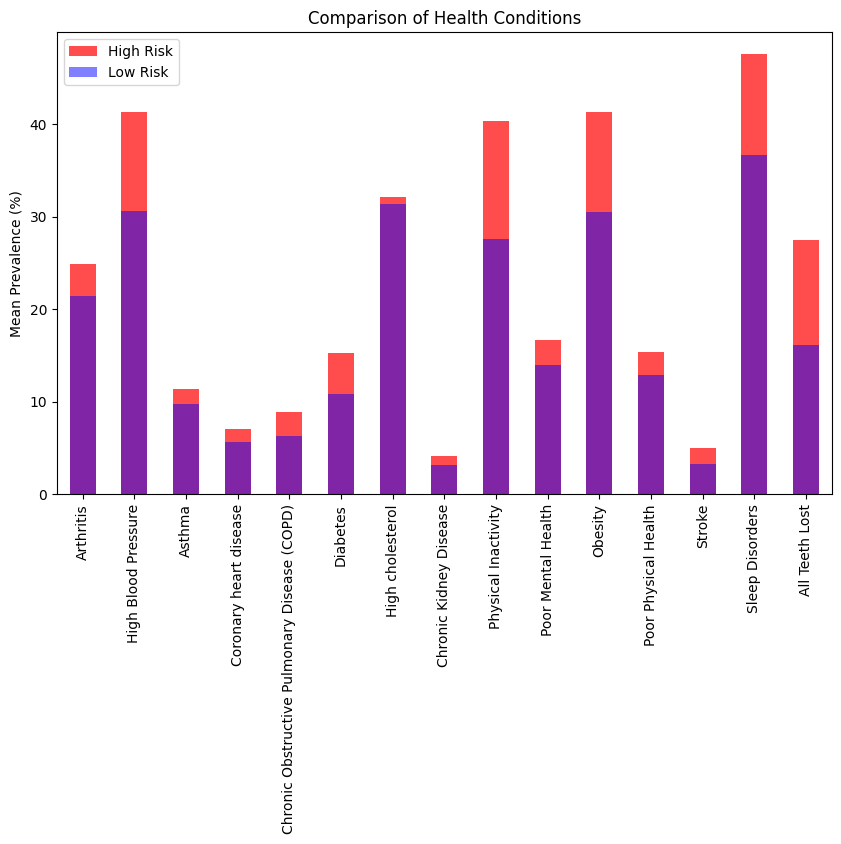

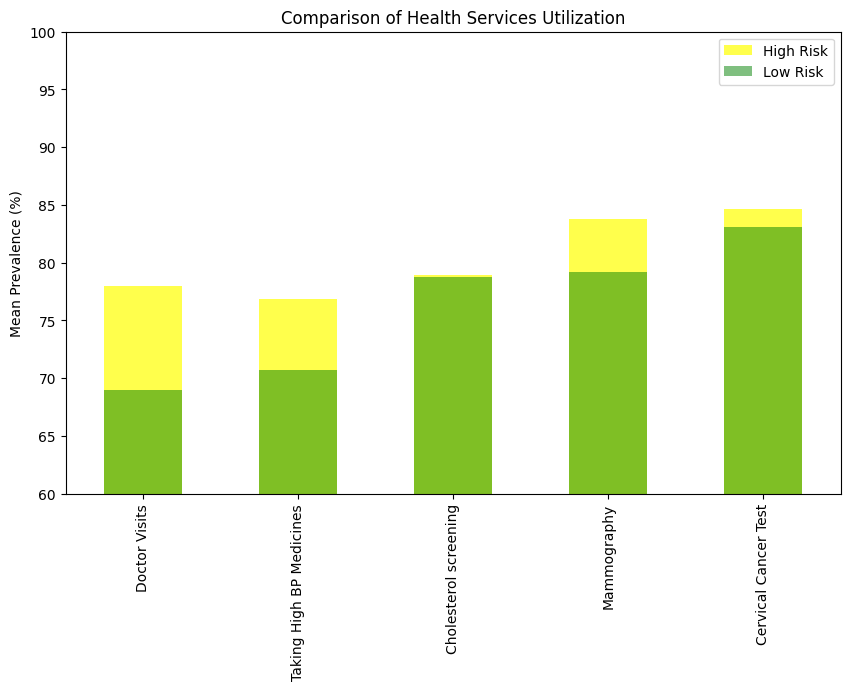

In [36]:
# Plotting health conditions
high_risk_health_conditions.plot(kind='bar', color='red', alpha=0.7, label='High Risk')
low_risk_health_conditions.plot(kind='bar', color='blue', alpha=0.5, label='Low Risk', figsize=(10, 6))
plt.title('Comparison of Health Conditions')
plt.ylabel('Mean Prevalence (%)')
plt.xticks(rotation=90)
plt.legend()
plt.show()

# Plotting health service utilization 
high_risk_health_services.plot(kind='bar', color='yellow', alpha=0.7, label='High Risk')
low_risk_health_services.plot(kind='bar', color='green', alpha=0.5, label='Low Risk', figsize=(10, 6))
plt.title('Comparison of Health Services Utilization')
plt.ylabel('Mean Prevalence (%)')
plt.ylim(60,100)
plt.xticks(rotation=90)
plt.legend()
plt.show()


## **Step 3:** Filtering High Risk Areas- Access, Health, Utilization  

In [37]:
# Define high health risk/utilization as being above the 75th percentile for each column
health_services_high_threshold = merged_df[health_services].quantile(0.75)
health_conditions_high_threshold = merged_df[health_conditions].quantile(0.75)

# Create risk indicator columns for high health risk/utilization
for service in health_services:
    merged_df[f'High_{service}'] = merged_df[service] > health_services_high_threshold[service]

for condition in health_conditions:
    merged_df[f'High_{condition}'] = merged_df[condition] > health_conditions_high_threshold[condition]

print(f"Thresholds of health conditions:\n{health_conditions_high_threshold}\n")
print(f"Thresholds of health service utilization:\n{health_services_high_threshold}")

Thresholds of health conditions:
ARTHRITIS_CrudePrev    25.1
BPHIGH_CrudePrev       34.9
CASTHMA_CrudePrev      10.7
CHD_CrudePrev           6.7
COPD_CrudePrev          7.6
DIABETES_CrudePrev     12.9
HIGHCHOL_CrudePrev     34.4
KIDNEY_CrudePrev        3.6
LPA_CrudePrev          33.8
MHLTH_CrudePrev        16.4
OBESITY_CrudePrev      35.6
PHLTH_CrudePrev        15.4
STROKE_CrudePrev        3.8
SLEEP_CrudePrev        40.6
TEETHLOST_CrudePrev    21.3
Name: 0.75, dtype: float64

Thresholds of health service utilization:
CHECKUP_CrudePrev       73.3
BPMED_CrudePrev         75.9
CHOLSCREEN_CrudePrev    82.7
MAMMOUSE_CrudePrev      81.5
PAPTEST_CrudePrev       85.3
Name: 0.75, dtype: float64


In [38]:
chronic_health_conditions = [
    'ARTHRITIS_CrudePrev', 'BPHIGH_CrudePrev',
    'CASTHMA_CrudePrev', 'CHD_CrudePrev',
    'COPD_CrudePrev', 'DIABETES_CrudePrev', 'HIGHCHOL_CrudePrev',
    'KIDNEY_CrudePrev', 'MHLTH_CrudePrev', 'OBESITY_CrudePrev',
    'STROKE_CrudePrev','SLEEP_CrudePrev',
]

# Filter for high-risk access category (category=2)
high_access_risk_df = merged_df[merged_df['Risk_Category'] == 2]

# A combined indicator for high access risk and poor health outcomes
high_access_risk_df['High_Risk_Poor_Health'] = high_access_risk_df[[f'High_{condition}' for condition in chronic_health_conditions]].any(axis=1)

# A combined indicator for high access risk and high health service utilization
high_access_risk_df['High_Risk_High_Utilization'] = high_access_risk_df[[f'High_{service}' for service in health_services]].any(axis=1)

high_access_risk_df['Latitude'] = high_access_risk_df['Geolocation'].apply(lambda x: float(x.split(',')[0].strip('(')))
high_access_risk_df['Longitude'] = high_access_risk_df['Geolocation'].apply(lambda x: float(x.split(',')[1].strip(')')))

In [39]:
high_access_risk_df

,index,StateAbbr,PlaceName,PlaceFIPS,TractFIPS,Place_TractID,Population2010,ARTHRITIS_CrudePrev,ARTHRITIS_Crude95CI,BPHIGH_CrudePrev,BPHIGH_Crude95CI,BPMED_CrudePrev,BPMED_Crude95CI,CASTHMA_CrudePrev,CASTHMA_Crude95CI,CHD_CrudePrev,CHD_Crude95CI,CHECKUP_CrudePrev,CHECKUP_Crude95CI,CHOLSCREEN_CrudePrev,CHOLSCREEN_Crude95CI,COPD_CrudePrev,COPD_Crude95CI,DIABETES_CrudePrev,DIABETES_Crude95CI,HIGHCHOL_CrudePrev,HIGHCHOL_Crude95CI,KIDNEY_CrudePrev,KIDNEY_Crude95CI,LPA_CrudePrev,LPA_Crude95CI,MAMMOUSE_CrudePrev,MAMMOUSE_Crude95CI,MHLTH_CrudePrev,MHLTH_Crude95CI,OBESITY_CrudePrev,OBESITY_Crude95CI,PAPTEST_CrudePrev,PAPTEST_Crude95CI,PHLTH_CrudePrev,PHLTH_Crude95CI,SLEEP_CrudePrev,SLEEP_Crude95CI,STROKE_CrudePrev,STROKE_Crude95CI,TEETHLOST_CrudePrev,TEETHLOST_Crude95CI,Geolocation,FIPS,Food_Desert,Risk_Category,High_CHECKUP_CrudePrev,High_BPMED_CrudePrev,High_CHOLSCREEN_CrudePrev,High_MAMMOUSE_CrudePrev,High_PAPTEST_CrudePrev,High_ARTHRITIS_CrudePrev,High_BPHIGH_CrudePrev,High_CASTHMA_CrudePrev,High_CHD_CrudePrev,High_COPD_CrudePrev,High_DIABETES_CrudePrev,High_HIGHCHOL_CrudePrev,High_KIDNEY_CrudePrev,High_LPA_CrudePrev,High_MHLTH_CrudePrev,High_OBESITY_CrudePrev,High_PHLTH_CrudePrev,High_STROKE_CrudePrev,High_SLEEP_CrudePrev,High_TEETHLOST_CrudePrev,High_Risk_Poor_Health,High_Risk_High_Utilization,Latitude,Longitude
9158,9158,GA,Albany,1301052,13095000100,1301052-13095000100,5751,22.7,"(21.6, 23.6)",40.0,"(38.5, 41.3)",75.2,"(74.0, 76.4)",11.7,"(10.9, 12.7)",6.1,"( 5.7, 6.5)",77.6,"(76.5, 78.7)",77.3,"(75.1, 79.6)",8.2,"( 7.4, 9.2)",14.4,"(13.6, 15.2)",30.0,"(29.0, 31.0)",3.8,"( 3.6, 4.0)",41.6,"(38.2, 44.5)",84.5,"(82.1, 86.5)",17.6,"(15.8, 19.4)",43.6,"(41.7, 45.3)",84.5,"(81.9, 86.7)",15.0,"(13.7, 16.4)",49.7,"(47.9, 51.3)",4.5,"( 4.1, 4.9)",26.6,"(21.3, 32.6)","(31.57179200820, -84.0916661878)",13095,1,2,True,False,False,True,False,False,True,True,False,True,True,False,True,True,True,True,False,True,True,True,True,True,31.571792,-84.091666
9159,9159,GA,Albany,1301052,13095000200,1301052-13095000200,3123,28.7,"(27.3, 30.1)",49.5,"(48.0, 50.9)",79.7,"(78.6, 80.7)",13.5,"(12.3, 14.8)",9.2,"( 8.4, 10.1)",79.5,"(78.4, 80.5)",76.7,"(74.3, 79.1)",12.4,"(10.7, 14.0)",21.3,"(19.9, 22.6)",34.9,"(33.6, 36.2)",5.5,"( 5.1, 5.9)",51.1,"(47.6, 54.4)",84.7,"(81.8, 87.5)",21.2,"(19.0, 23.5)",50.0,"(48.3, 51.7)",84.6,"(81.9, 87.2)",21.1,"(19.0, 23.3)",53.1,"(51.2, 54.7)",7.5,"( 6.7, 8.3)",39.9,"(29.7, 50.2)","(31.57904097040, -84.1296291540)",13095,1,2,True,True,False,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,31.579041,-84.129629
9160,9160,GA,Albany,1301052,13095000400,1301052-13095000400,6276,22.4,"(21.4, 23.3)",34.2,"(33.1, 35.3)",74.4,"(73.4, 75.4)",10.3,"( 9.7, 11.0)",6.0,"( 5.5, 6.6)",75.1,"(74.3, 76.0)",78.5,"(76.7, 80.1)",7.4,"( 6.6, 8.4)",10.9,"(10.2, 11.6)",30.2,"(29.5, 31.1)",3.3,"( 3.1, 3.5)",35.1,"(32.5, 37.9)",82.3,"(79.6, 84.8)",15.0,"(13.5, 16.4)",35.3,"(33.9, 36.8)",84.3,"(82.2, 86.1)",12.7,"(11.6, 13.9)",43.9,"(42.3, 45.5)",3.6,"( 3.2, 3.9)",20.3,"(14.0, 28.1)","(31.61484136300, -84.1973866421)",13095,1,2,True,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,True,True,31.614841,-84.197387
9161,9161,GA,Albany,1301052,13095000501,1301052-13095000501,4798,20.8,"(20.1, 21.7)",31.6,"(30.6, 32.5)",75.1,"(74.3, 76.0)",9.3,"( 8.9, 9.7)",4.7,"( 4.4, 5.1)",76.3,"(75.7, 76.9)",83.2,"(82.1, 84.1)",5.4,"( 4.8, 6.0)",9.2,"( 8.7, 9.7)",29.3,"(28.7, 29.9)",2.6,"( 2.5, 2.8)",28.3,"(26.4, 30.2)",82.4,"(80.1, 84.3)",11.6,"(10.7, 12.5)",31.3,"(30.2, 32.5)",85.4,"(84.0, 86.8)",9.6,"( 8.9, 10.4)",41.5,"(40.2, 42.7)",2.7,"( 2.5, 3.0)",12.1,"( 8.8, 15.7)","(31.59865853510, -84.2282377893)",13095,1,2,True,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,True,31.598659,-84.228238
9162,9162,GA,Albany,1301052,13095000502,1301052-13095000502,4151,28.3,"(26.8, 30.0)",37.7,"(36.2, 3

In [40]:
# Aggregate by state
state_health_risk_summary = high_access_risk_df.groupby('StateAbbr').agg({
    'High_Risk_Poor_Health': 'sum',
    'High_Risk_High_Utilization': 'sum'
}).sort_values(by='High_Risk_Poor_Health', ascending=False)  

state_health_risk_summary

,High_Risk_Poor_Health,High_Risk_High_Utilization
StateAbbr,,
GA,24,24


In [41]:
# Filter the DataFrame where both conditions are true and then sum the 'Population2010' column
total_population_high_foodaccess_health_risk_and_high_utilization = high_access_risk_df[
    (high_access_risk_df['High_Risk_Poor_Health'] == True) & 
    (high_access_risk_df['High_Risk_High_Utilization'] == True)
]['Population2010'].sum()

print("Total population with high food access,health risk and high health service utilization:", total_population_high_foodaccess_health_risk_and_high_utilization)


Total population with high food access,health risk and high health service utilization: 71139


In [42]:
high_foodaccess_health_risk_and_high_utilization_df = high_access_risk_df[
    (high_access_risk_df['High_Risk_Poor_Health'] == True) & 
    (high_access_risk_df['High_Risk_High_Utilization'] == True)
]
high_foodaccess_health_risk_and_high_utilization_df

,index,StateAbbr,PlaceName,PlaceFIPS,TractFIPS,Place_TractID,Population2010,ARTHRITIS_CrudePrev,ARTHRITIS_Crude95CI,BPHIGH_CrudePrev,BPHIGH_Crude95CI,BPMED_CrudePrev,BPMED_Crude95CI,CASTHMA_CrudePrev,CASTHMA_Crude95CI,CHD_CrudePrev,CHD_Crude95CI,CHECKUP_CrudePrev,CHECKUP_Crude95CI,CHOLSCREEN_CrudePrev,CHOLSCREEN_Crude95CI,COPD_CrudePrev,COPD_Crude95CI,DIABETES_CrudePrev,DIABETES_Crude95CI,HIGHCHOL_CrudePrev,HIGHCHOL_Crude95CI,KIDNEY_CrudePrev,KIDNEY_Crude95CI,LPA_CrudePrev,LPA_Crude95CI,MAMMOUSE_CrudePrev,MAMMOUSE_Crude95CI,MHLTH_CrudePrev,MHLTH_Crude95CI,OBESITY_CrudePrev,OBESITY_Crude95CI,PAPTEST_CrudePrev,PAPTEST_Crude95CI,PHLTH_CrudePrev,PHLTH_Crude95CI,SLEEP_CrudePrev,SLEEP_Crude95CI,STROKE_CrudePrev,STROKE_Crude95CI,TEETHLOST_CrudePrev,TEETHLOST_Crude95CI,Geolocation,FIPS,Food_Desert,Risk_Category,High_CHECKUP_CrudePrev,High_BPMED_CrudePrev,High_CHOLSCREEN_CrudePrev,High_MAMMOUSE_CrudePrev,High_PAPTEST_CrudePrev,High_ARTHRITIS_CrudePrev,High_BPHIGH_CrudePrev,High_CASTHMA_CrudePrev,High_CHD_CrudePrev,High_COPD_CrudePrev,High_DIABETES_CrudePrev,High_HIGHCHOL_CrudePrev,High_KIDNEY_CrudePrev,High_LPA_CrudePrev,High_MHLTH_CrudePrev,High_OBESITY_CrudePrev,High_PHLTH_CrudePrev,High_STROKE_CrudePrev,High_SLEEP_CrudePrev,High_TEETHLOST_CrudePrev,High_Risk_Poor_Health,High_Risk_High_Utilization,Latitude,Longitude
9158,9158,GA,Albany,1301052,13095000100,1301052-13095000100,5751,22.7,"(21.6, 23.6)",40.0,"(38.5, 41.3)",75.2,"(74.0, 76.4)",11.7,"(10.9, 12.7)",6.1,"( 5.7, 6.5)",77.6,"(76.5, 78.7)",77.3,"(75.1, 79.6)",8.2,"( 7.4, 9.2)",14.4,"(13.6, 15.2)",30.0,"(29.0, 31.0)",3.8,"( 3.6, 4.0)",41.6,"(38.2, 44.5)",84.5,"(82.1, 86.5)",17.6,"(15.8, 19.4)",43.6,"(41.7, 45.3)",84.5,"(81.9, 86.7)",15.0,"(13.7, 16.4)",49.7,"(47.9, 51.3)",4.5,"( 4.1, 4.9)",26.6,"(21.3, 32.6)","(31.57179200820, -84.0916661878)",13095,1,2,True,False,False,True,False,False,True,True,False,True,True,False,True,True,True,True,False,True,True,True,True,True,31.571792,-84.091666
9159,9159,GA,Albany,1301052,13095000200,1301052-13095000200,3123,28.7,"(27.3, 30.1)",49.5,"(48.0, 50.9)",79.7,"(78.6, 80.7)",13.5,"(12.3, 14.8)",9.2,"( 8.4, 10.1)",79.5,"(78.4, 80.5)",76.7,"(74.3, 79.1)",12.4,"(10.7, 14.0)",21.3,"(19.9, 22.6)",34.9,"(33.6, 36.2)",5.5,"( 5.1, 5.9)",51.1,"(47.6, 54.4)",84.7,"(81.8, 87.5)",21.2,"(19.0, 23.5)",50.0,"(48.3, 51.7)",84.6,"(81.9, 87.2)",21.1,"(19.0, 23.3)",53.1,"(51.2, 54.7)",7.5,"( 6.7, 8.3)",39.9,"(29.7, 50.2)","(31.57904097040, -84.1296291540)",13095,1,2,True,True,False,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,31.579041,-84.129629
9160,9160,GA,Albany,1301052,13095000400,1301052-13095000400,6276,22.4,"(21.4, 23.3)",34.2,"(33.1, 35.3)",74.4,"(73.4, 75.4)",10.3,"( 9.7, 11.0)",6.0,"( 5.5, 6.6)",75.1,"(74.3, 76.0)",78.5,"(76.7, 80.1)",7.4,"( 6.6, 8.4)",10.9,"(10.2, 11.6)",30.2,"(29.5, 31.1)",3.3,"( 3.1, 3.5)",35.1,"(32.5, 37.9)",82.3,"(79.6, 84.8)",15.0,"(13.5, 16.4)",35.3,"(33.9, 36.8)",84.3,"(82.2, 86.1)",12.7,"(11.6, 13.9)",43.9,"(42.3, 45.5)",3.6,"( 3.2, 3.9)",20.3,"(14.0, 28.1)","(31.61484136300, -84.1973866421)",13095,1,2,True,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,True,True,31.614841,-84.197387
9161,9161,GA,Albany,1301052,13095000501,1301052-13095000501,4798,20.8,"(20.1, 21.7)",31.6,"(30.6, 32.5)",75.1,"(74.3, 76.0)",9.3,"( 8.9, 9.7)",4.7,"( 4.4, 5.1)",76.3,"(75.7, 76.9)",83.2,"(82.1, 84.1)",5.4,"( 4.8, 6.0)",9.2,"( 8.7, 9.7)",29.3,"(28.7, 29.9)",2.6,"( 2.5, 2.8)",28.3,"(26.4, 30.2)",82.4,"(80.1, 84.3)",11.6,"(10.7, 12.5)",31.3,"(30.2, 32.5)",85.4,"(84.0, 86.8)",9.6,"( 8.9, 10.4)",41.5,"(40.2, 42.7)",2.7,"( 2.5, 3.0)",12.1,"( 8.8, 15.7)","(31.59865853510, -84.2282377893)",13095,1,2,True,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,True,31.598659,-84.228238
9162,9162,GA,Albany,1301052,13095000502,1301052-13095000502,4151,28.3,"(26.8, 30.0)",37.7,"(36.2, 3

### Visualization- A map with high risk tracts in Albany, GA (within Dougherty County)

In [43]:
m = folium.Map(location=[31.5439, -84.2279], zoom_start=10)  
high_foodaccess_health_risk_and_high_utilization_df['TractFIPS'] = high_foodaccess_health_risk_and_high_utilization_df['TractFIPS'].astype('str')

# Add markers for each high-risk tract
for idx, row in high_foodaccess_health_risk_and_high_utilization_df.iterrows():
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        radius=6,
        color='darkred',
        fill=True,
        fill_color='red',
        fill_opacity=0.8,
        popup=folium.Popup(f"{row['TractFIPS'][5:]},{row['PlaceName']} - Severe Risk: Access, Health and Utilization \n Population:{row['Population2010']}", max_width=300),
    ).add_to(m)

# Display
m.save('Tri-fold_risk_Albany_tracts.html')
# m 


### Visualization - A map with tracts within cities at high health risk and high health service utilization

In [44]:
test_df = merged_df.copy()
test_df['TractFIPS'] = test_df['TractFIPS'].astype('str')

In [45]:
# Define the highest health risk and high utilization flags across all chronic conditions
test_df['Highest_Health_Risk'] = (test_df[[f'High_{condition}' for condition in chronic_health_conditions]].all(axis=1))
test_df['Highest_Health_Service_Utilization'] = (test_df[[f'High_{service}' for service in health_services]].all(axis=1))

# Filter for tracts with either high health risk or high service utilization
high_risk_or_utilization_df = test_df[
    test_df['Highest_Health_Risk'] | test_df['Highest_Health_Service_Utilization']
]

# Parse the 'Geolocation' if not already done
high_risk_or_utilization_df['Latitude'] = high_risk_or_utilization_df['Geolocation'].apply(lambda x: float(x.split(',')[0].strip('(')))
high_risk_or_utilization_df['Longitude'] = high_risk_or_utilization_df['Geolocation'].apply(lambda x: float(x.split(',')[1].strip(')')))


# Create the base map
m = folium.Map(location=[37.8, -96], zoom_start=5)

# Add markers for high health risk and high utilization
for idx, row in high_risk_or_utilization_df.iterrows():
    # Determine the color based on the type of risk
    if row['Highest_Health_Risk'] and row['Highest_Health_Service_Utilization']:
        color = 'purple'  # Both high risk and high utilization
    elif row['Highest_Health_Risk']:
        color = 'red'    # High health risk
    elif row['Highest_Health_Service_Utilization']:
        color = 'blue'   # High utilization

    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        radius=6,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        popup=folium.Popup(f"{row['TractFIPS'],row['PlaceName'],row['StateAbbr']} - {('High Health Risk' if row['Highest_Health_Risk'] else '')}, {('High Utilization' if row['Highest_Health_Service_Utilization'] else '')}", max_width=300),
    ).add_to(m)

m.save('tract_level_health_risks_utilization_map.html')
# m  # Display 

In [46]:
test_df

,index,StateAbbr,PlaceName,PlaceFIPS,TractFIPS,Place_TractID,Population2010,ARTHRITIS_CrudePrev,ARTHRITIS_Crude95CI,BPHIGH_CrudePrev,BPHIGH_Crude95CI,BPMED_CrudePrev,BPMED_Crude95CI,CASTHMA_CrudePrev,CASTHMA_Crude95CI,CHD_CrudePrev,CHD_Crude95CI,CHECKUP_CrudePrev,CHECKUP_Crude95CI,CHOLSCREEN_CrudePrev,CHOLSCREEN_Crude95CI,COPD_CrudePrev,COPD_Crude95CI,DIABETES_CrudePrev,DIABETES_Crude95CI,HIGHCHOL_CrudePrev,HIGHCHOL_Crude95CI,KIDNEY_CrudePrev,KIDNEY_Crude95CI,LPA_CrudePrev,LPA_Crude95CI,MAMMOUSE_CrudePrev,MAMMOUSE_Crude95CI,MHLTH_CrudePrev,MHLTH_Crude95CI,OBESITY_CrudePrev,OBESITY_Crude95CI,PAPTEST_CrudePrev,PAPTEST_Crude95CI,PHLTH_CrudePrev,PHLTH_Crude95CI,SLEEP_CrudePrev,SLEEP_Crude95CI,STROKE_CrudePrev,STROKE_Crude95CI,TEETHLOST_CrudePrev,TEETHLOST_Crude95CI,Geolocation,FIPS,Food_Desert,Risk_Category,High_CHECKUP_CrudePrev,High_BPMED_CrudePrev,High_CHOLSCREEN_CrudePrev,High_MAMMOUSE_CrudePrev,High_PAPTEST_CrudePrev,High_ARTHRITIS_CrudePrev,High_BPHIGH_CrudePrev,High_CASTHMA_CrudePrev,High_CHD_CrudePrev,High_COPD_CrudePrev,High_DIABETES_CrudePrev,High_HIGHCHOL_CrudePrev,High_KIDNEY_CrudePrev,High_LPA_CrudePrev,High_MHLTH_CrudePrev,High_OBESITY_CrudePrev,High_PHLTH_CrudePrev,High_STROKE_CrudePrev,High_SLEEP_CrudePrev,High_TEETHLOST_CrudePrev,Highest_Health_Risk,Highest_Health_Service_Utilization
0,0,AL,Birmingham,107000,1073000100,0107000-01073000100,3042,31.2,"(30.1, 32.2)",47.7,"(46.6, 48.8)",77.8,"(77.0, 78.6)",13.4,"(12.7, 14.3)",7.8,"( 7.3, 8.3)",74.8,"(74.1, 75.5)",78.6,"(77.1, 80.0)",11.3,"(10.1, 12.5)",17.4,"(16.6, 18.3)",35.3,"(34.5, 36.2)",4.3,"( 4.0, 4.5)",44.0,"(41.4, 46.5)",82.8,"(80.2, 84.7)",20.5,"(18.9, 22.1)",46.4,"(45.2, 47.5)",85.0,"(83.4, 86.6)",20.5,"(18.9, 22.2)",45.5,"(44.3, 46.5)",5.5,"( 5.0, 5.9)",28.9,"(23.7, 35.1)","(33.57943283260, -86.7228323926)",01073,0,1,True,True,False,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False
1,1,AL,Birmingham,107000,1073000300,0107000-01073000300,2735,30.5,"(29.3, 31.7)",48.2,"(47.1, 49.3)",78.5,"(77.6, 79.3)",12.5,"(11.7, 13.3)",8.6,"( 7.9, 9.3)",72.1,"(71.4, 72.8)",76.0,"(74.6, 77.4)",11.9,"(10.6, 13.2)",19.8,"(18.6, 20.9)",36.8,"(35.9, 37.7)",4.6,"( 4.3, 4.9)",47.5,"(44.9, 49.9)",83.2,"(80.4, 85.7)",21.2,"(19.6, 22.7)",47.8,"(46.6, 48.9)",83.8,"(81.9, 85.6)",22.2,"(20.4, 24.0)",44.5,"(43.2, 45.7)",6.1,"( 5.5, 6.8)",32.9,"(25.5, 40.2)","(33.54282086860, -86.7524339780)",01073,0,1,False,True,False,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False
2,2,AL,Birmingham,107000,1073000400,0107000-01073000400,3338,31.5,"(30.2, 32.9)",49.1,"(47.8, 50.4)",79.4,"(78.5, 80.3)",13.3,"(12.4, 14.4)",7.5,"( 6.9, 8.2)",76.6,"(75.8, 77.4)",80.2,"(78.5, 82.0)",10.5,"( 9.2, 12.0)",18.4,"(17.3, 19.6)",35.6,"(34.5, 36.6)",4.2,"( 4.0, 4.5)",43.0,"(40.0, 45.9)",83.5,"(80.6, 85.9)",18.8,"(17.1, 20.7)",45.7,"(44.3, 46.9)",84.6,"(82.3, 86.8)",19.4,"(17.5, 21.4)",45.7,"(44.2, 47.0)",5.6,"( 5.0, 6.2)",28.6,"(22.0, 35.1)","(33.56324496330, -86.7640474064)",01073,0,1,True,True,False,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False
3,3,AL,Birmingham,107000,1073000500,0107000-01073000500,2864,35.0,"(33.5, 36.4)",54.1,"(52.7, 55.3)",82.1,"(81.3, 82.9)",13.6,"(12.7, 14.7)",9.6,"( 8.7, 10.6)",78.2,"(77.4, 78.9)",80.5,"(78.7, 82.1)",12.3,"(10.7, 14.0)",22.4,"(21.1, 23.8)",38.4,"(37.2, 39.5)",5.3,"( 4.9, 5.7)",45.9,"(42.6, 48.9)",83.8,"(81.1, 86.3)",19.4,"(17.7, 21.2)",48.0,"(46.5, 49.3)",84.3,"(82.1, 86.5)",21.7,"(19.7, 23.9)",46.1,"(44.5, 47.4)",7.3,"( 6.5, 8.2)",34.0,"(24.4, 42.9)","(33.54424045940, -86.7749130719)",01073,0,1,True,True,False,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False
4,4,AL,Birmingham,107000,1073000700,0107000-01073000700,2577,36.3,"(34.9, 37.7)",56.5,"(55.1, 57.8)",81.8,"(80.8, 82.7)",14.7,"(13.6, 16.0)",11.4,"(10.4, 12.5)",78.1,"(77.0, 79.1)",77.4,"(75.2, 79.6)",14.8,"(12.9, 16.8)",25.0,"(

In [47]:
# test_df[(test_df['TractFIPS']=='13095011400')]
print(f"State with most tracts with highest health risk: {test_df[test_df['Highest_Health_Risk'] == True].groupby('StateAbbr').size().idxmax()}")
print(f"City with most tracts with highest health risk : {test_df[test_df['Highest_Health_Risk'] == True].groupby('PlaceName').size().idxmax()}")

print(f"State with most tracts with highest health service utilization: {test_df[test_df['Highest_Health_Service_Utilization'] == True].groupby('StateAbbr').size().idxmax()}")
print(f"City with most tracts highest health service utilization: {test_df[test_df['Highest_Health_Service_Utilization'] == True].groupby('PlaceName').size().idxmax()}")



State with most tracts with highest health risk: MI
City with most tracts with highest health risk : Detroit
State with most tracts with highest health service utilization: NY
City with most tracts highest health service utilization: New York


Observations:
- Detroit in Michigan has the most tracts with high prevalence of all chronic health conditions. (https://www.beckersasc.com/asc-news/the-cities-with-the-worst-healthcare.html)
- New York City, NY has the most tracts with high prevalence of healthcare service utilization.

# Observations

Albany, located in Dougherty County, **Georgia** faces all three risks. The data-driven decision to concentrate efforts in Albany stems from several alarming indicators:

**Tri-fold Challenge:** Albany represents a confluence of high food access risk, worsened health conditions, and elevated health service utilization. This tri-fold challenge is critical as it not only affects the current state of public health but forecasts escalating future costs and health service demands if unaddressed.

**Suspected Food Swamp:** The prevalence of fast food outlets overshadows healthier food options, categorizing Albany as a food swamp (These are areas where fast food outlets and convenience stores far outnumber healthier food alternatives, promoting unhealthy eating habits that contribute directly to the community’s adverse health outcomes). This environment promotes poor dietary choices that directly contribute to the health issues prevalent in the community.


Validation: https://growingfoodconnections.org/publications/briefs/exploring-stories-of-opportunity/dougherty-county-georgia/#:~:text=Dougherty%20County%20has%20the%20highest,food%20insecurity%20in%20the%20nation.&text=Nearly%2027%20percent%20of%20county,affordable%20and%20culturally%20acceptable%20foods.

In [48]:
print(f"Total population in tri-fold risk area in the US: {total_population_high_foodaccess_health_risk_and_high_utilization}")


Total population in tri-fold risk area in the US: 71139


In [49]:
high_foodaccess_health_risk_and_high_utilization_df.head()

,index,StateAbbr,PlaceName,PlaceFIPS,TractFIPS,Place_TractID,Population2010,ARTHRITIS_CrudePrev,ARTHRITIS_Crude95CI,BPHIGH_CrudePrev,BPHIGH_Crude95CI,BPMED_CrudePrev,BPMED_Crude95CI,CASTHMA_CrudePrev,CASTHMA_Crude95CI,CHD_CrudePrev,CHD_Crude95CI,CHECKUP_CrudePrev,CHECKUP_Crude95CI,CHOLSCREEN_CrudePrev,CHOLSCREEN_Crude95CI,COPD_CrudePrev,COPD_Crude95CI,DIABETES_CrudePrev,DIABETES_Crude95CI,HIGHCHOL_CrudePrev,HIGHCHOL_Crude95CI,KIDNEY_CrudePrev,KIDNEY_Crude95CI,LPA_CrudePrev,LPA_Crude95CI,MAMMOUSE_CrudePrev,MAMMOUSE_Crude95CI,MHLTH_CrudePrev,MHLTH_Crude95CI,OBESITY_CrudePrev,OBESITY_Crude95CI,PAPTEST_CrudePrev,PAPTEST_Crude95CI,PHLTH_CrudePrev,PHLTH_Crude95CI,SLEEP_CrudePrev,SLEEP_Crude95CI,STROKE_CrudePrev,STROKE_Crude95CI,TEETHLOST_CrudePrev,TEETHLOST_Crude95CI,Geolocation,FIPS,Food_Desert,Risk_Category,High_CHECKUP_CrudePrev,High_BPMED_CrudePrev,High_CHOLSCREEN_CrudePrev,High_MAMMOUSE_CrudePrev,High_PAPTEST_CrudePrev,High_ARTHRITIS_CrudePrev,High_BPHIGH_CrudePrev,High_CASTHMA_CrudePrev,High_CHD_CrudePrev,High_COPD_CrudePrev,High_DIABETES_CrudePrev,High_HIGHCHOL_CrudePrev,High_KIDNEY_CrudePrev,High_LPA_CrudePrev,High_MHLTH_CrudePrev,High_OBESITY_CrudePrev,High_PHLTH_CrudePrev,High_STROKE_CrudePrev,High_SLEEP_CrudePrev,High_TEETHLOST_CrudePrev,High_Risk_Poor_Health,High_Risk_High_Utilization,Latitude,Longitude
9158,9158,GA,Albany,1301052,13095000100,1301052-13095000100,5751,22.7,"(21.6, 23.6)",40.0,"(38.5, 41.3)",75.2,"(74.0, 76.4)",11.7,"(10.9, 12.7)",6.1,"( 5.7, 6.5)",77.6,"(76.5, 78.7)",77.3,"(75.1, 79.6)",8.2,"( 7.4, 9.2)",14.4,"(13.6, 15.2)",30.0,"(29.0, 31.0)",3.8,"( 3.6, 4.0)",41.6,"(38.2, 44.5)",84.5,"(82.1, 86.5)",17.6,"(15.8, 19.4)",43.6,"(41.7, 45.3)",84.5,"(81.9, 86.7)",15.0,"(13.7, 16.4)",49.7,"(47.9, 51.3)",4.5,"( 4.1, 4.9)",26.6,"(21.3, 32.6)","(31.57179200820, -84.0916661878)",13095,1,2,True,False,False,True,False,False,True,True,False,True,True,False,True,True,True,True,False,True,True,True,True,True,31.571792,-84.091666
9159,9159,GA,Albany,1301052,13095000200,1301052-13095000200,3123,28.7,"(27.3, 30.1)",49.5,"(48.0, 50.9)",79.7,"(78.6, 80.7)",13.5,"(12.3, 14.8)",9.2,"( 8.4, 10.1)",79.5,"(78.4, 80.5)",76.7,"(74.3, 79.1)",12.4,"(10.7, 14.0)",21.3,"(19.9, 22.6)",34.9,"(33.6, 36.2)",5.5,"( 5.1, 5.9)",51.1,"(47.6, 54.4)",84.7,"(81.8, 87.5)",21.2,"(19.0, 23.5)",50.0,"(48.3, 51.7)",84.6,"(81.9, 87.2)",21.1,"(19.0, 23.3)",53.1,"(51.2, 54.7)",7.5,"( 6.7, 8.3)",39.9,"(29.7, 50.2)","(31.57904097040, -84.1296291540)",13095,1,2,True,True,False,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,31.579041,-84.129629
9160,9160,GA,Albany,1301052,13095000400,1301052-13095000400,6276,22.4,"(21.4, 23.3)",34.2,"(33.1, 35.3)",74.4,"(73.4, 75.4)",10.3,"( 9.7, 11.0)",6.0,"( 5.5, 6.6)",75.1,"(74.3, 76.0)",78.5,"(76.7, 80.1)",7.4,"( 6.6, 8.4)",10.9,"(10.2, 11.6)",30.2,"(29.5, 31.1)",3.3,"( 3.1, 3.5)",35.1,"(32.5, 37.9)",82.3,"(79.6, 84.8)",15.0,"(13.5, 16.4)",35.3,"(33.9, 36.8)",84.3,"(82.2, 86.1)",12.7,"(11.6, 13.9)",43.9,"(42.3, 45.5)",3.6,"( 3.2, 3.9)",20.3,"(14.0, 28.1)","(31.61484136300, -84.1973866421)",13095,1,2,True,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,True,True,31.614841,-84.197387
9161,9161,GA,Albany,1301052,13095000501,1301052-13095000501,4798,20.8,"(20.1, 21.7)",31.6,"(30.6, 32.5)",75.1,"(74.3, 76.0)",9.3,"( 8.9, 9.7)",4.7,"( 4.4, 5.1)",76.3,"(75.7, 76.9)",83.2,"(82.1, 84.1)",5.4,"( 4.8, 6.0)",9.2,"( 8.7, 9.7)",29.3,"(28.7, 29.9)",2.6,"( 2.5, 2.8)",28.3,"(26.4, 30.2)",82.4,"(80.1, 84.3)",11.6,"(10.7, 12.5)",31.3,"(30.2, 32.5)",85.4,"(84.0, 86.8)",9.6,"( 8.9, 10.4)",41.5,"(40.2, 42.7)",2.7,"( 2.5, 3.0)",12.1,"( 8.8, 15.7)","(31.59865853510, -84.2282377893)",13095,1,2,True,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,True,31.598659,-84.228238
9162,9162,GA,Albany,1301052,13095000502,1301052-13095000502,4151,28.3,"(26.8, 30.0)",37.7,"(36.2, 3

In [50]:
high_access_risk_df['All_Conditions_High'] = high_access_risk_df[
    [f'High_{condition}' for condition in chronic_health_conditions]
].all(axis=1)

high_access_risk_df['All_Utilization_High'] = high_access_risk_df[
    [f'High_{condition}' for condition in health_services]
].all(axis=1)
# Filter for tracts where all health condition flags are True
worst_health_tracts = high_access_risk_df[high_access_risk_df['All_Conditions_High']]

# Calculate the total population in these tracts
total_population_worst_health = worst_health_tracts['Population2010'].sum()
print(f"Estimated engaged population in the worst health tracts: {total_population_worst_health}")
# high_access_risk_df

Estimated engaged population in the worst health tracts: 20774


In Dougherty, Georgia, the analysis identifies approximately **71,139** residents living in tracts categorized as high-risk due to significant food access issues and related health challenges. 


In [51]:
# Calculate the prevalence of each condition flagged as high in Albany
condition_prevalence = {
    condition: high_access_risk_df[high_access_risk_df['PlaceName'] == 'Albany'][f'High_{condition}'].sum()
    for condition in chronic_health_conditions
}

# Convert the dictionary into a DataFrame for better handling
condition_prevalence_df = pd.DataFrame(list(condition_prevalence.items()), columns=['Condition', 'High_Risk_Count'])

# Sort the conditions based on the count of high-risk flags in descending order
sorted_conditions = condition_prevalence_df.sort_values(by='High_Risk_Count', ascending=False)

top_conditions = sorted_conditions
print("The most prevalent conditions in Albany with their high-risk counts are:")
print(top_conditions)


The most prevalent conditions in Albany with their high-risk counts are:
              Condition  High_Risk_Count
11      SLEEP_CrudePrev               23
9     OBESITY_CrudePrev               19
1      BPHIGH_CrudePrev               17
2     CASTHMA_CrudePrev               16
10     STROKE_CrudePrev               16
4        COPD_CrudePrev               15
5    DIABETES_CrudePrev               14
7      KIDNEY_CrudePrev               14
3         CHD_CrudePrev               13
8       MHLTH_CrudePrev               13
0   ARTHRITIS_CrudePrev               12
6    HIGHCHOL_CrudePrev               10


Analysis has revealed that several chronic health conditions are highly prevalent among the population of Albany, with significant numbers of individuals flagged as high-risk across multiple health metrics. This detailed overview of the conditions, along with the number of tracts affected, provides a clear picture of the community's health landscape:

- Sleep Disorders affect 23 tracts, making it the most prevalent condition.
- Physical Inactivity (LPA_CrudePrev) impacts 20 tracts, highlighting a significant lifestyle issue.
- Obesity (OBESITY_CrudePrev) is a close third, affecting 19 tracts, a major concern given its associated health complications.
- High Blood Pressure (BPHIGH_CrudePrev) and Asthma (CASTHMA_CrudePrev) are also notably prevalent, affecting 17 and 16 tracts respectively.
Given that these conditions are prevalent in nearly the entirety of the analyzed tracts (with the top condition affecting 92% of tracts), it is evident that a substantial portion of Albany's population is at a heightened risk of health issues that can be exacerbated by poor nutrition.

Focusing on these chronic conditions is not only critical due to their prevalence but also because of the direct impact that improved food access can have on managing and potentially alleviating these conditions. Here's why this focus can be particularly beneficial:

Direct Impact on Health Outcomes: Improving access to nutritious food can directly influence the management and prevention of conditions like obesity, high blood pressure, and diabetes. For example, diets rich in fruits, vegetables, and whole grains are essential in managing obesity and high blood pressure, which are prevalent in Albany.




In [52]:
# Filter access_df for high-risk FIPS codes from the previous analysis
high_risk_fips = high_access_risk_df['FIPS'].unique()  # Assuming high_access_risk_df contains the high-risk tracts
high_risk_demographics = access_df[access_df['FIPS'].isin(high_risk_fips)]

# racial or ethnic group in these high-risk areas
racial_composition = high_risk_demographics[[ 'PCT_LACCESS_WHITE15', 'PCT_LACCESS_BLACK15', 'PCT_LACCESS_HISP15', 'PCT_LACCESS_NHASIAN15', 'PCT_LACCESS_NHNA15','PCT_LACCESS_NHPI15','PCT_LACCESS_MULTIR15']]
print("Average racial composition in high-risk areas:")
racial_composition


Average racial composition in high-risk areas:


,PCT_LACCESS_WHITE15,PCT_LACCESS_BLACK15,PCT_LACCESS_HISP15,PCT_LACCESS_NHASIAN15,PCT_LACCESS_NHNA15,PCT_LACCESS_NHPI15,PCT_LACCESS_MULTIR15
433,9.233354,28.778562,0.699432,0.240341,0.084736,0.036184,0.70002


From the data, it is evident that the Black community in this area has the highest percentage of limited access to nutritious food, significantly higher than other groups. This may suggest that they might be the most impacted by food access issues and therefore could benefit the most from targeted interventions aimed at improving food accessibility and quality.

Representing approximately 28.78% of the population with limited access to nutritious food, this group stands out as particularly vulnerable within the context of food swamps — areas saturated with poor nutritional options.

In [53]:
high_risk_demographics

,index,FIPS,State,County,LACCESS_POP10,LACCESS_POP15,PCH_LACCESS_POP_10_15,PCT_LACCESS_POP10,PCT_LACCESS_POP15,LACCESS_LOWI10,LACCESS_LOWI15,PCH_LACCESS_LOWI_10_15,PCT_LACCESS_LOWI10,PCT_LACCESS_LOWI15,LACCESS_HHNV10,LACCESS_HHNV15,PCH_LACCESS_HHNV_10_15,PCT_LACCESS_HHNV10,PCT_LACCESS_HHNV15,LACCESS_SNAP15,PCT_LACCESS_SNAP15,LACCESS_CHILD10,LACCESS_CHILD15,LACCESS_CHILD_10_15,PCT_LACCESS_CHILD10,PCT_LACCESS_CHILD15,LACCESS_SENIORS10,LACCESS_SENIORS15,PCH_LACCESS_SENIORS_10_15,PCT_LACCESS_SENIORS10,PCT_LACCESS_SENIORS15,LACCESS_WHITE15,PCT_LACCESS_WHITE15,LACCESS_BLACK15,PCT_LACCESS_BLACK15,LACCESS_HISP15,PCT_LACCESS_HISP15,LACCESS_NHASIAN15,PCT_LACCESS_NHASIAN15,LACCESS_NHNA15,PCT_LACCESS_NHNA15,LACCESS_NHPI15,PCT_LACCESS_NHPI15,LACCESS_MULTIR15,PCT_LACCESS_MULTIR15,Low_Access,Low_Income,Food_Desert,Risk_Category
433,433,13095,GA,Dougherty,39406.19114,36949.568249,-6.234104,41.671011,39.073196,19438.202453,21398.008971,10.082242,20.555388,22.627832,1875.41273,1982.002049,5.683513,5.136991,5.428953,3819.820167,10.462967,10427.706892,9868.597884,-5.361764,11.027026,10.435783,4593.47908,4299.147121,-6.407604,4.857483,4.546235,8731.520986,9.233354,27214.447399,28.778562,661.417505,0.699432,227.278011,0.240341,80.130629,0.084736,34.217564,0.036184,661.973673,0.70002,True,True,1,2
